In [161]:
import os
os.chdir('/Users/beth/Documents/Metis/metis_project_2/metis_project2')
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [642]:
import math

## Exploring the data

Import the dataframe scraped from Discogs.com and Spotify.com

In [630]:
with open('final_record_1000_manual_update.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [633]:
df[df['artists']=="Hendrix"]

,artists,albums,artist_links,album_links,release_year,label,release_country,total_artist_albums,artist_last_years,artist_first_years,...,median_price,highest_price,last_sold,styles,genres,number_for_sale,versions,top_artists_spotify_name,spotify_monthly_listeners,top_artists_orig_name
273,Hendrix,Band Of Gypsys,https://www.discogs.com/artist/110593-Jimi-Hen...,https://www.discogs.com/Hendrix-Band-Of-Gypsys...,1970,Capitol Records,US,183,2019,1967,...,16.50,76.47,11 Sep 20,"[Psychedelic Rock, Hard Rock, Acid Rock, Rhyth...",[Rock],32,280,Jimi Hendrix,8497262,Hendrix


In [636]:
np.log(df.loc[273,'median_price'])

2.803360380906535

In [644]:
math.exp(np.log(df.loc[273,'median_price']))

16.5

In [925]:
np.log(20.35)

3.013080911888604

In [924]:
df[df['release_year']>1990].sort_values('spotify_monthly_listeners')[['artists','albums','spotify_monthly_listeners','median_price']].tail()

,artists,albums,spotify_monthly_listeners,median_price
448,Michael Jackson,Dangerous,23635338.0,49.99
550,Kendrick Lamar,"Good Kid, M.A.A.d City",25732149.0,6.21
258,Kendrick Lamar,"Good Kid, M.A.A.d City",25732149.0,20.35
472,Kendrick Lamar,Damn.,25732149.0,29.64
340,Kendrick Lamar,To Pimp A Butterfly,25732149.0,26.95


nan

There are some null values, but only 2 nulls for the target value category (Median price).
Lowest price and highest price will be ignored.

I need to convert a lot of these columns to numbers, and since NaN values can't be converted to integers, but can be convert to floats, I converted the values to floats

In [635]:
df['release_year'] = df['release_year'].astype('float')
df['total_artist_albums'] = df['total_artist_albums'].astype('float')
df['artist_last_years'] = df['artist_last_years'].astype('float')
df['artist_first_years'] = df['artist_first_years'].astype('float')
df['number_of_songs'] = df['number_of_songs'].astype('float')
df['users_have'] = df['users_have'].astype('float')
df['users_want'] = df['users_want'].astype('float')
df['user_rating'] = df['user_rating'].astype('float')
df['versions'] = df['versions'].astype('float')
df['spotify_monthly_listeners'] = df['spotify_monthly_listeners'].astype('float')

df['median_price'] = df['median_price'].astype('str')
df['median_price'] = df['median_price'].str.replace(',','')
df['median_price'] = df['median_price'].astype('float')

df['number_for_sale'] = df['number_for_sale'].str.replace(',','')
df['number_for_sale'] = df['number_for_sale'].astype('float')

df.drop('highest_price', axis=1, inplace=True)
df.drop('lowest_price', axis=1, inplace=True)

### Creating new variables based on year or time differences

I changed some of the date and time columns to datetime objects, and I calculated some differences between times as new variables. For example, years_after_first_album represents the number of years the album of interest was released after the artist's first album was. I dropped columns that would be highly correlated with these new columns.

In [166]:
#the time since last sold as a number of days
df['last_sold'] = pd.to_datetime(df['last_sold'])
df['time_since_sold'] = datetime.today()-df['last_sold']
df = df.drop('last_sold', axis=1)
df['time_since_sold'] = df['time_since_sold'].dt.days

#the number of years the album was released after the artist's first album was 
#(measure of how established the artist was)
df['years_after_first_album']=df['release_year']-df['artist_first_years']
df=df.drop('artist_first_years',axis=1)

#the number of years since any album containing that artist's material was produced
#(measure of the relevance of the artist today)
df['years_since_any_album']=2020-df['artist_last_years']
df=df.drop('artist_last_years', axis=1)

#the number of years it has been since the album was released
df['years_since_release']=2020-df['release_year']
df=df.drop('release_year', axis=1)

#the average song length in minutes as a decimal float number
df['average_song_length'] = pd.to_datetime(df['average_song_length'])
df['average_song_length'] = df['average_song_length'].dt.hour + df['average_song_length'].dt.minute/60

I also dropped the link columns

In [167]:
df.drop(['artist_links', 'album_links', 'first_release_links'], axis=1, inplace=True)

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artists                    1000 non-null   object 
 1   albums                     1000 non-null   object 
 2   label                      1000 non-null   object 
 3   release_country            999 non-null    object 
 4   total_artist_albums        989 non-null    float64
 5   number_of_songs            1000 non-null   float64
 6   average_song_length        794 non-null    float64
 7   index                      1000 non-null   int64  
 8   users_have                 1000 non-null   float64
 9   users_want                 1000 non-null   float64
 10  user_rating                1000 non-null   float64
 11  median_price               998 non-null    float64
 12  styles                     1000 non-null   object 
 13  genres                     1000 non-null   object

### Looking at the distribution of the target variable (median price)

I looked at a histogram of my target variable 'median_price' and saw it was pretty skewed toward 0, and had a few very high outliers. I thought that transforming my target variable (predicting it thought a transformation link function) would be a good idea. I tried both the inverse (1/x) and the log (log(x)) of my target, and in a standard linear model using all of the data, the log of 'median_price' had a better R^2, meaning that the variables could predict the log 

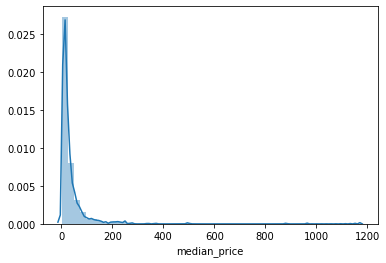

In [169]:
sns.distplot(df['median_price'])

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


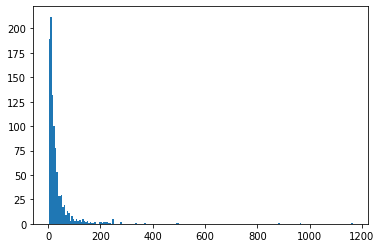

In [170]:
plt.hist(df['median_price'],bins=200);
#the warning is due to 2 np.nan values


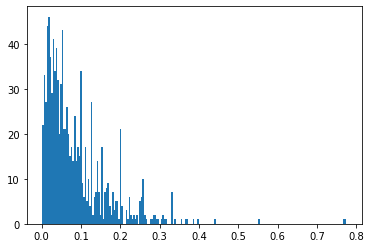

In [171]:
plt.hist(1/df['median_price'],bins=200);

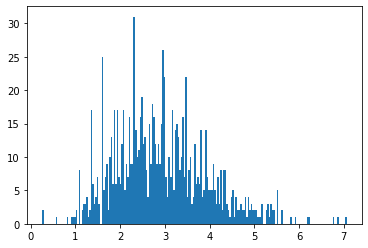

In [172]:
plt.hist(np.log(df['median_price']),bins=200);

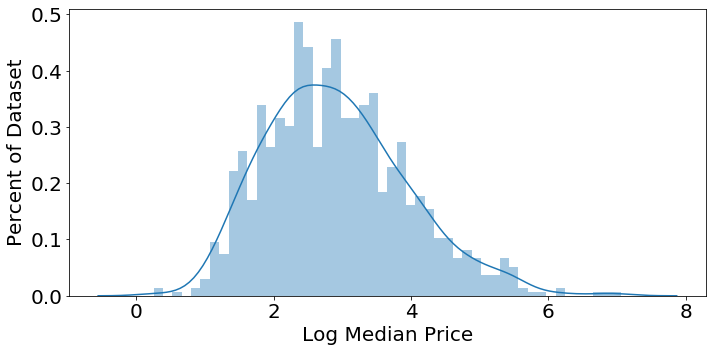

In [173]:
plt.figure(figsize=(10,5))
sns.distplot(np.log(df['median_price']),bins=50)
             
plt.xlabel('Log Median Price', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Percent of Dataset', fontsize=20)
plt.yticks(fontsize=20);

plt.tight_layout()
plt.savefig('Log Median Price Dist.tiff')

I looked at the Pearson correlation between the continous variables in my dataframe, and added the log and inverse of median_price, to see if the correlations were better with either of these targets

In [174]:
df['log_median_price']=np.log(df['median_price'])
df['inv_median_price']=1/df['median_price']

### Plotting Pearson correlations between the predictors, target, and transformed targets

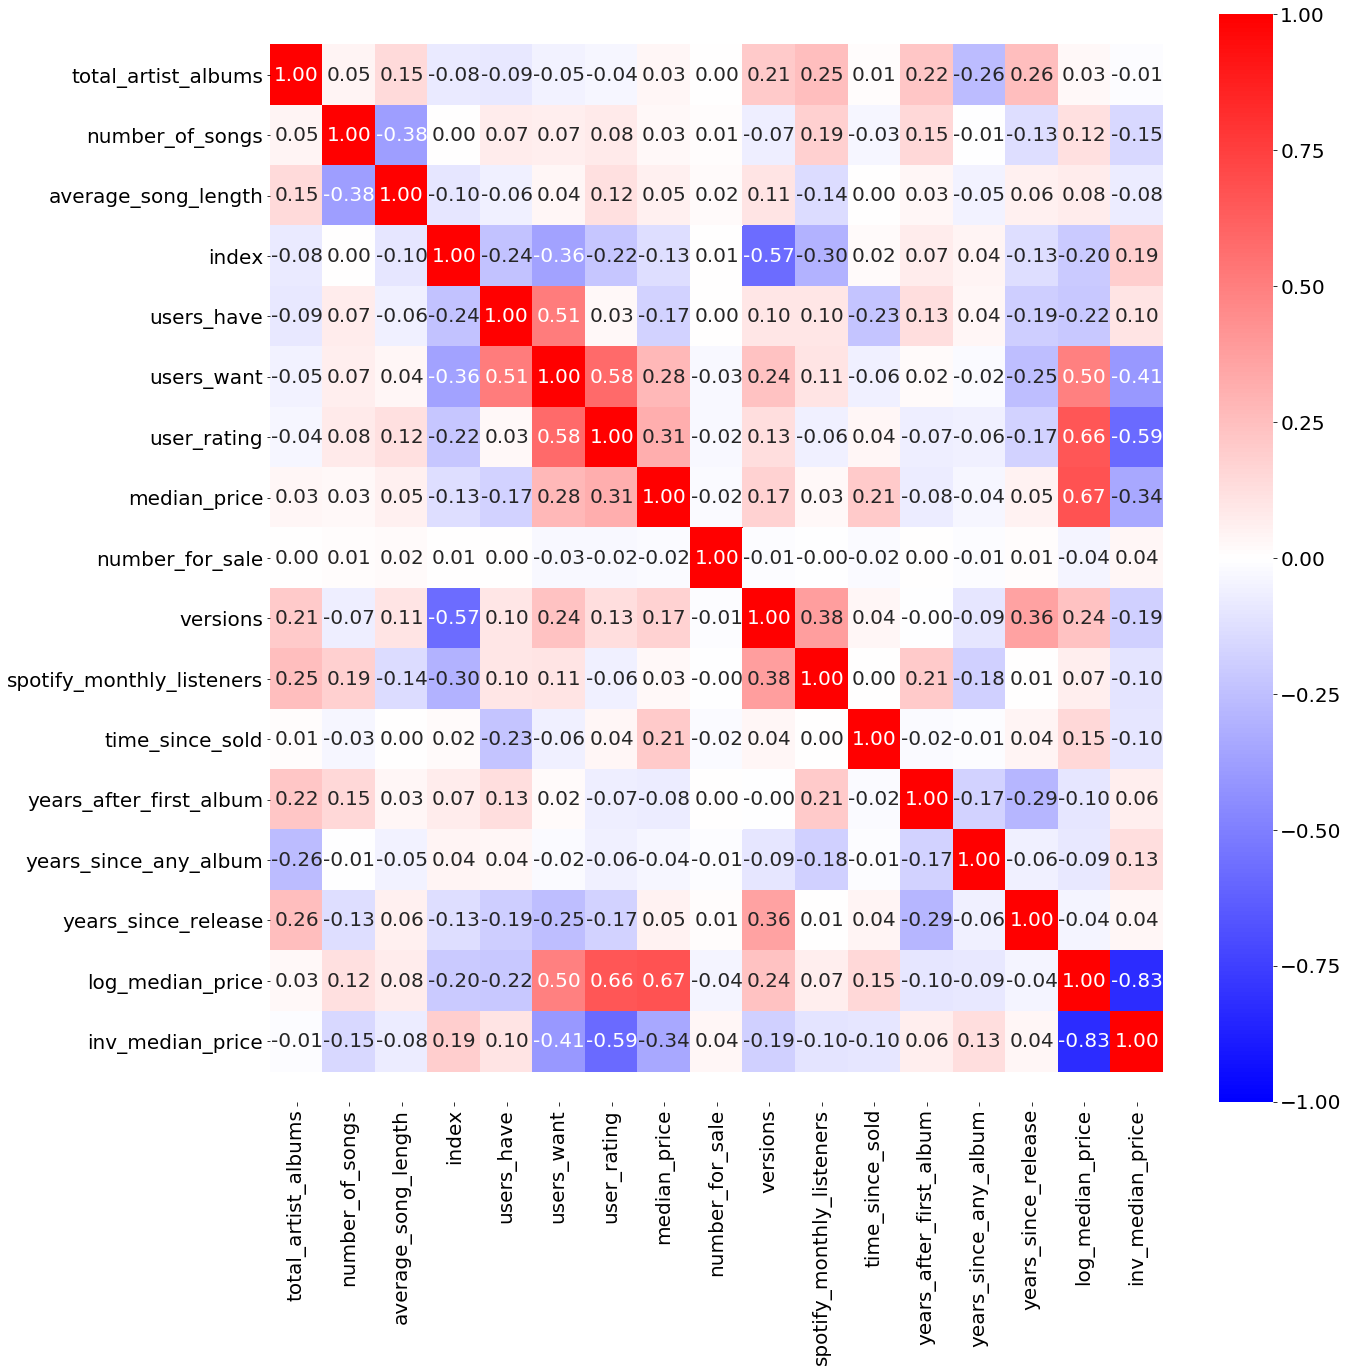

In [25]:
plt.rcParams['font.size'] = 20

plt.figure(figsize=(20,20))

sns.heatmap(df.corr(), cmap="bwr", annot=True, vmin=-1, vmax=1, fmt='.2f')

plt.gca().set_ylim(len(df.corr())+0.5, -0.5);  # quick fix to make sure viz isn't cut off

From the above heatmap, it looks like my target median_price has a positive correlation with the number of versions (re-pressings) of the album made, as well as the user rating and the number of users that want the album. It has a negative correlation with the number for sale, the number of users that have the album, and the index (position in top 1000 collected albums list - not sure I want to use this variable in modeling). 

The inverse of median_price and log of median_price has higher linear correlations with the predictor variables. For inverse, the sign on the relationships is inverted. The log of the median price has the highest linear correlations with the predictor variables, so I am going to predict the log of the median value.


The variable 'spotify_monthly_listeners' is correlated with number of songs, and total number of artist albums, which makes sense because the more material the artist has produced, the more Spotify listens there may be by chance. However, it has no or very week correlation with the target varaible. 

The variable 'number_for_sale' seems the least correlated with any other variable, and only correlated with the target. 

The variable 'avg_song_length' has the most missing values, and isn't correlated with the target or other variables other than 'number_of_songs' so I am going to drop it.

In [175]:
df.drop('average_song_length', axis=1, inplace=True)

In [176]:
df.drop(['inv_median_price','median_price'], axis=1, inplace=True)

Based on intial pairplots I realized there were two very incorrect valuse of an album being released 20 years before the artist's first album, and over a million of a record for sale. I corrected these valuse in the dataframe

In [177]:
df.loc[541,'number_for_sale'] = 220
df.loc[983,'years_after_first_album']=0

### Pairplots to look at linearity of relationships, and for interesting patterns

This first pair plot using the continous variables that are related to things intrinsic to the album (not related to users)

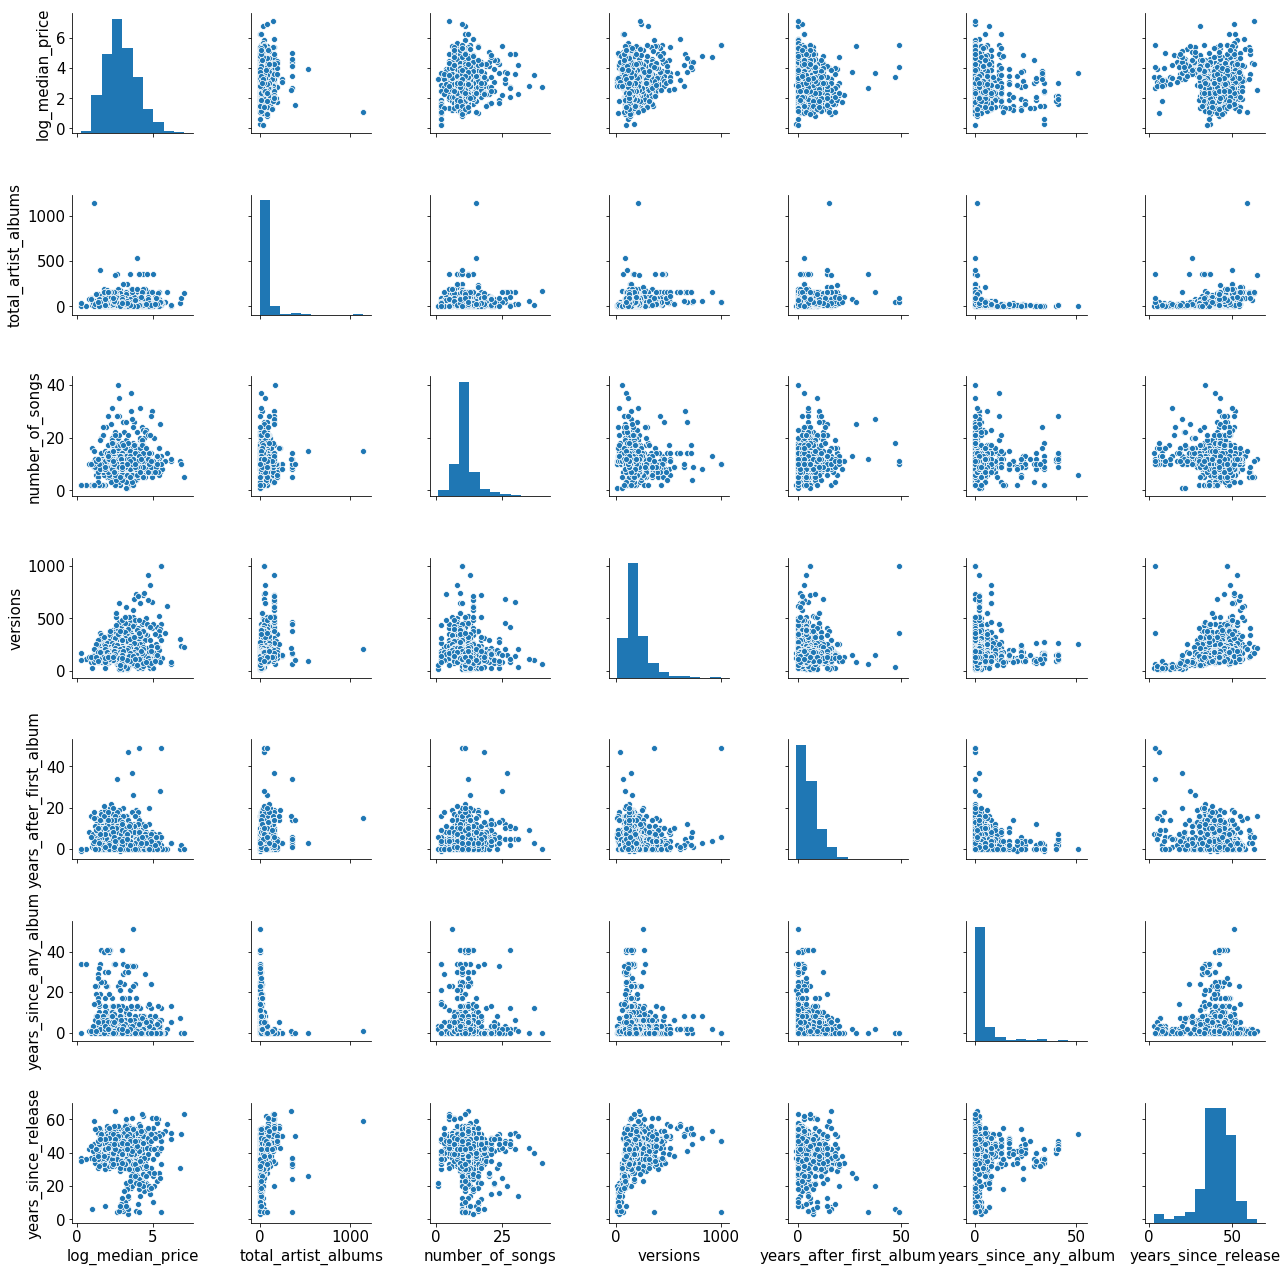

In [132]:
plt.rcParams['font.size'] = 15
sns.pairplot(data=df[['log_median_price','total_artist_albums','number_of_songs','versions','years_after_first_album','years_since_any_album','years_since_release']])

I can see the log_median_price has a somewhat linear positive relationship with number of songs and number of versions of that album. I interpret this as albums with more material being more valuable, and albums that earn money being re-pressed serveral times by record companies.

It has a somewhat linear negative relationshp with years_after_first_album and years_since_any_album. I interpret this as artist's early albums being more expensive, and record companies continuing to put out albums using material from artists they know will add more value to the record. Maybe the relationship with years_after_first_album is quadratic - newer compeliation albums of popular artists could also be more expensive.

The log_median_price has an unusual relationship with 'years_since_release'. It seems that album prices drop off sharply after a certain age. This may be because at that point the albums are all used and more likely damaged. I explore this plot more below.

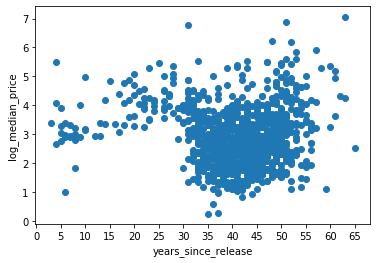

In [178]:
#It seems like when an album is less than 30 years old it sells for a higher price
#It might be useful to convert this into a categorical varialble (>30yr or <30yr)
#I keep the original 'years_since_release' since there seems to be a slight positive linear relationship overall

plt.scatter(df['years_since_release'], df['log_median_price'])
plt.xticks(np.arange(0, 70, step=5))
plt.xlabel('years_since_release')
plt.ylabel('log_median_price');

In [179]:
df['less_than_30_year_old']=df['years_since_release'] <= 30
df['more_than_30_year_old']=df['years_since_release'] > 30

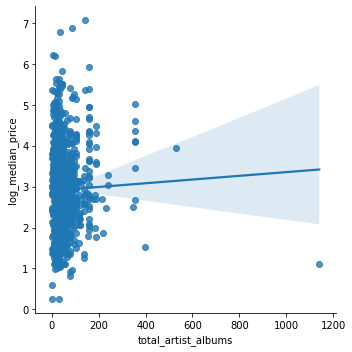

In [180]:
sns.lmplot('total_artist_albums','log_median_price',data=df)

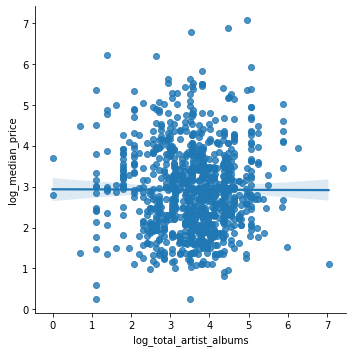

In [181]:
df['log_total_artist_albums']=np.log(df['total_artist_albums'])
sns.lmplot('log_total_artist_albums','log_median_price',data=df)

In [182]:
df.drop(['log_total_artist_albums', 'total_artist_albums'],axis=1,inplace=True)

Now I plotted several predicters related to how users interact with the albums and artists on Discogs and Spotify.

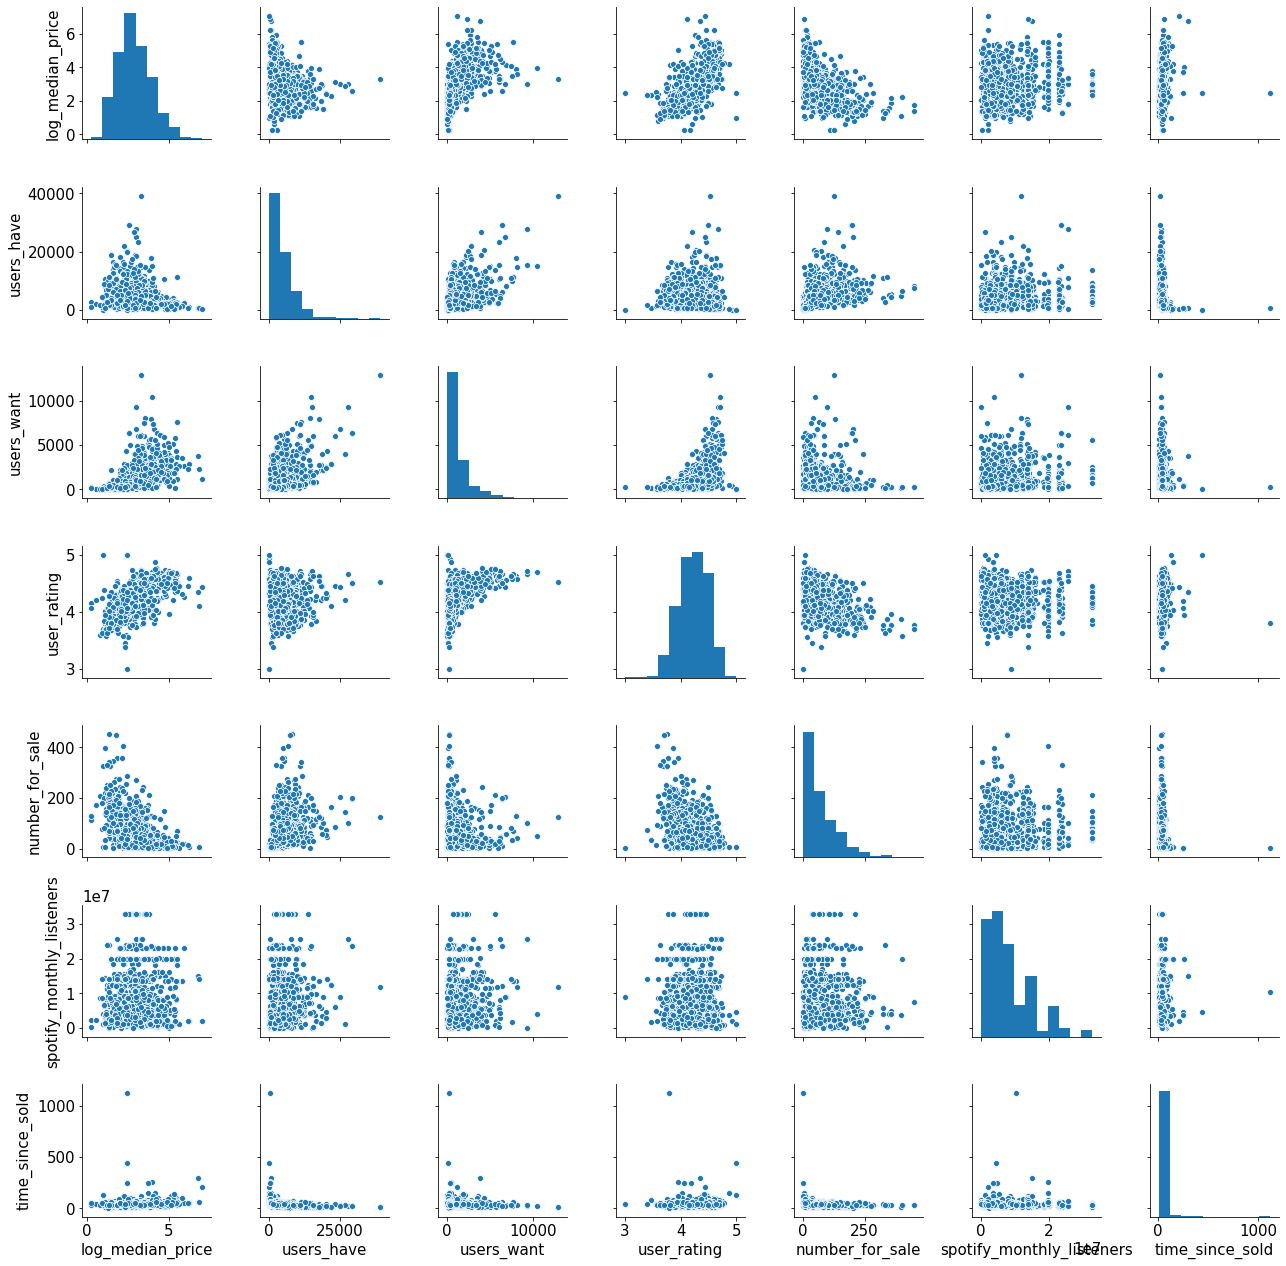

In [146]:
sns.pairplot(data=df[['log_median_price','users_have','users_want','user_rating','number_for_sale','spotify_monthly_listeners','time_since_sold']])

Here, 'log_median_price' has a positive relationship with users_want and user_rating. The relationship with users_want is not linear. 

'log_median_price' also has a negative non-linear relationship with number_for_sale. 

The variable 'time_since_sold' looked skewed toward 0, so I also tried log transforming it. Here a log transformation improved the linear relationship between it and 'log_median_price'.

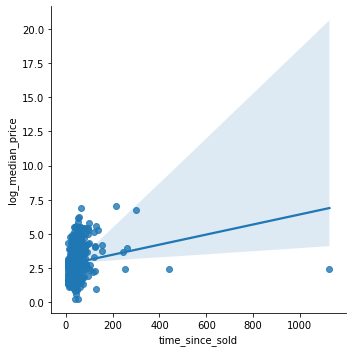

In [183]:
sns.lmplot('time_since_sold','log_median_price',data=df)

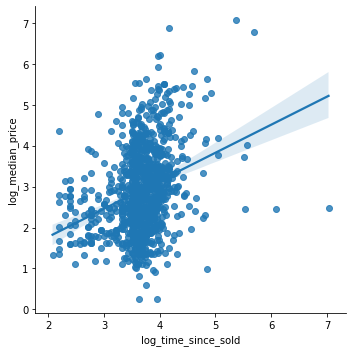

In [184]:
df['log_time_since_sold']=np.log(df['time_since_sold'])
sns.lmplot('log_time_since_sold','log_median_price',data=df)

In [185]:
df.drop('time_since_sold',axis=1,inplace=True)

### Important: 
Variables closely linked to market value like, supply (number_for_sale, time_since_sold), demand (users_want, users_have) were really strong predictors, especially once interaction terms were generated. In the end I decided to pursue a model that didn't use these variables, because it would be more challenging and the results may be more interesting.

## Creating the categorical variable columns

### Genre dummies

First, I viewed the genres and styles columns to look for popular tags. Sometimes a tag appears in genre and sometimes it appears in styles, tags are also non-exclusive because an album can be a fusion of multiple styles. I found all rows that contained a tag of interest and created a column for that tag of 1's and 0's.

In [186]:
df['styles'].value_counts().head(20)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[Pop Rock]                        59
[Hard Rock]                       32
[Synth-pop]                       29
[Prog Rock]                       23
[Hard Rock, Heavy Metal]          22
[Classic Rock]                    20
[Heavy Metal]                     20
[]                                18
[Indie Rock]                      13
[Pop Rock, Classic Rock]          12
[Pop Rock, Synth-pop]             10
[New Wave]                        10
[Folk Rock]                       10
[Blues Rock]                       9
[Alternative Rock, Indie Rock]     9
[New Wave, Synth-pop]              8
[Hard Rock, Pop Rock]              8
[Hard Rock, Prog Rock]             8
[Soft Rock, Pop Rock]              7
[New Wave, Post-Punk]              7
Name: styles, dtype: int64

In [187]:
df['Classic_Rock'] = df['styles'].apply(lambda x: 'Classic Rock' in x)
df['Classic_Rock_2'] = df['genres'].apply(lambda y: 'Classic Rock' in y)
df['Classic_Rock'] = df['Classic_Rock'] | df['Classic_Rock_2']
df.drop('Classic_Rock_2',axis=1,inplace=True)

In [188]:
df['Pop_Rock'] = df['styles'].apply(lambda x: 'Pop Rock' in x)
df['Pop_Rock_2'] = df['genres'].apply(lambda y: 'Pop Rock' in y)
df['Pop_Rock'] = df['Pop_Rock'] | df['Pop_Rock_2']
df.drop('Pop_Rock_2',axis=1,inplace=True)

In [189]:
df['Prog_Rock'] = df['styles'].apply(lambda x: 'Prog Rock' in x)
df['Prog_Rock_2'] = df['genres'].apply(lambda y: 'Prog Rock' in y)
df['Prog_Rock'] = df['Prog_Rock'] | df['Prog_Rock_2']
df.drop('Prog_Rock_2',axis=1,inplace=True)

In [190]:
df['Heavy_Metal'] = df['styles'].apply(lambda x: 'Hard Rock' in x or 'Heavy Metal' in x)
df['Heavy_Metal_2'] = df['genres'].apply(lambda y: 'Hard Rock' in y or 'Heavy Metal' in y)
df['Heavy_Metal'] = df['Heavy_Metal_2'] | df['Heavy_Metal']
df.drop('Heavy_Metal_2',axis=1,inplace=True)

In [191]:
df['Folk'] = df['styles'].apply(lambda x: 'Folk' in x or 'Folk Rock' in x)
df['Folk_2'] = df['genres'].apply(lambda y: 'Folk' in 'Fold Rock' in y)
df['Folk'] = df['Folk_2'] | df['Folk']
df.drop('Folk_2',axis=1,inplace=True)

In [192]:
df['New_Wave'] = df['styles'].apply(lambda x: 'New Wave' in x or 'Synth-Pop' in x)
df['New_Wave_2'] = df['genres'].apply(lambda y: 'New Wave' in y or 'Synth-Pop' in y)
df['New_Wave'] = df['New_Wave'] | df['New_Wave_2']
df.drop('New_Wave_2',axis=1,inplace=True)

In [193]:
df['Electronic'] = df['styles'].apply(lambda x: 'Electronic' in x)
df['Electronic_2'] = df['genres'].apply(lambda y: 'Electronic' in y)
df['Electronic'] = df['Electronic'] | df['Electronic_2']
df.drop('Electronic_2',axis=1,inplace=True)

In [194]:
df['Hip_Hop'] = df['styles'].apply(lambda x: 'Hip Hop' in x)
df['Hip_Hop_2'] = df['genres'].apply(lambda y: 'Hip Hop' in y)
df['Hip_Hop'] = df['Hip_Hop'] | df['Hip_Hop_2']
df.drop('Hip_Hop_2',axis=1,inplace=True)

In [195]:
df['Blues'] = df['styles'].apply(lambda x: 'Blues' in x or 'Blues Rock' in x)
df['Blues_2'] = df['genres'].apply(lambda y: 'Blues' in y or 'Blues Rock' in y)
df['Blues'] = df['Blues'] | df['Blues_2']
df.drop('Blues_2',axis=1,inplace=True)

In [196]:
df['Jazz'] = df['styles'].apply(lambda x: 'Jazz' in x)
df['Jazz_2'] = df['genres'].apply(lambda y: 'Jazz' in y)
df['Jazz'] = df['Jazz'] | df['Jazz_2']
df.drop('Jazz_2',axis=1,inplace=True)

In [197]:
df['Funk'] = df['styles'].apply(lambda x: 'Funk / Soul' in x)
df['Funk_2'] = df['genres'].apply(lambda y: 'Funk / Soul' in y)
df['Funk'] = df['Funk'] | df['Funk_2']
df.drop('Funk_2',axis=1,inplace=True)

In [198]:
df['Soundtrack'] = df['styles'].apply(lambda x: 'Stage & Screen' in x or 'Soundtrack' in x)
df['Soundtrack_2'] = df['genres'].apply(lambda y: 'Stage & Screen' in y or 'Soundtrack' in y)
df['Soundtrack'] = df['Soundtrack'] | df['Soundtrack_2']
df.drop('Soundtrack_2',axis=1,inplace=True)

In [199]:
df['Classic_Rock'] = df['Classic_Rock'].astype(int)
df['Pop_Rock'] = df['Pop_Rock'].astype(int)
df['Prog_Rock'] = df['Prog_Rock'].astype(int)
df['Heavy_Metal'] = df['Heavy_Metal'].astype(int)
df['Folk'] = df['Folk'].astype(int)
df['New_Wave'] = df['New_Wave'].astype(int)
df['Electronic'] = df['Electronic'].astype(int)
df['Hip_Hop'] = df['Hip_Hop'].astype(int)
df['Jazz'] = df['Jazz'].astype(int)
df['Funk'] = df['Funk'].astype(int)
df['Soundtrack'] = df['Soundtrack'].astype(int)

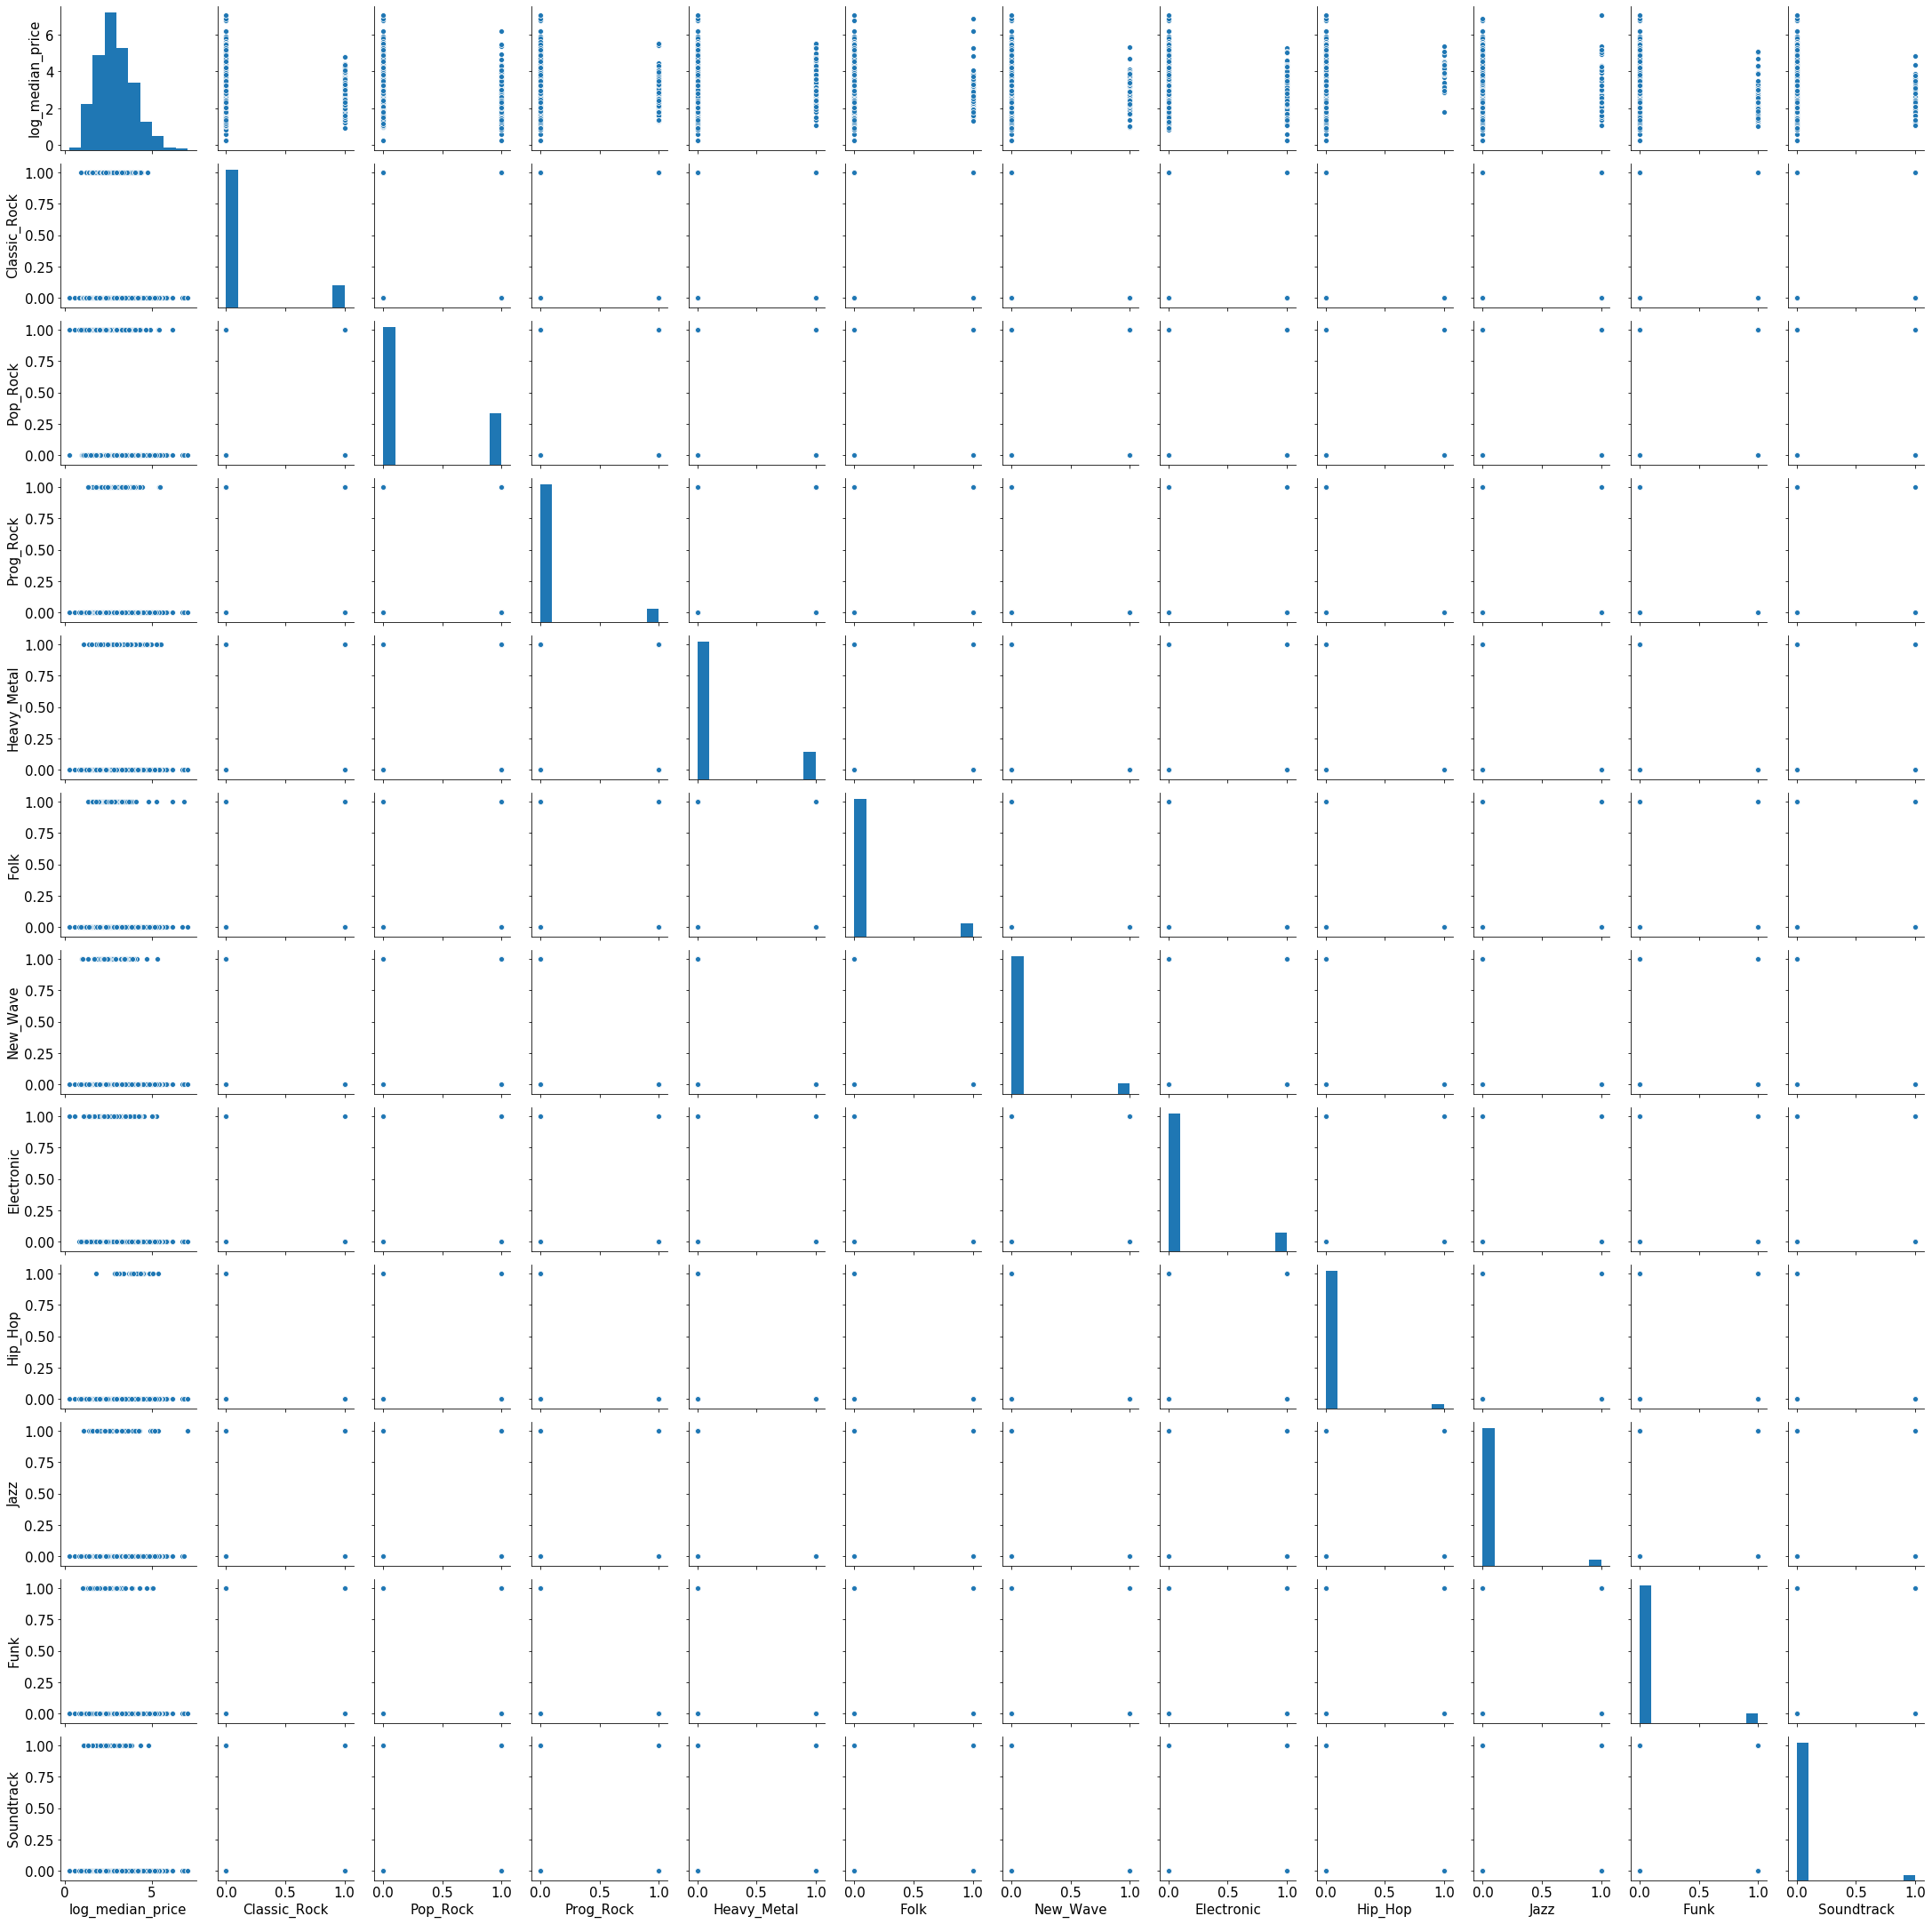

In [318]:
sns.pairplot(df[['log_median_price','Classic_Rock','Pop_Rock','Prog_Rock','Heavy_Metal','Folk','New_Wave','Electronic','Hip_Hop','Jazz','Funk','Soundtrack']])

From the above plot I can see some differences in the price distributions of the different genres/styles

There are the most Pop_Rock albums, they are usually older and cheaper.

No handles with labels found to put in legend.


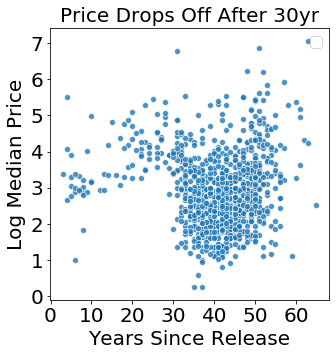

In [593]:
plt.figure(figsize=(5,5))
sns.scatterplot(df['years_since_release'],df['log_median_price'],alpha=0.8)

plt.xlabel('Years Since Release', fontsize=20)
plt.ylabel('Log Median Price', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.title('Price Drops Off After 30yr', fontsize=20)

plt.savefig('Years.tiff')

Jazz albums are amoung the oldest

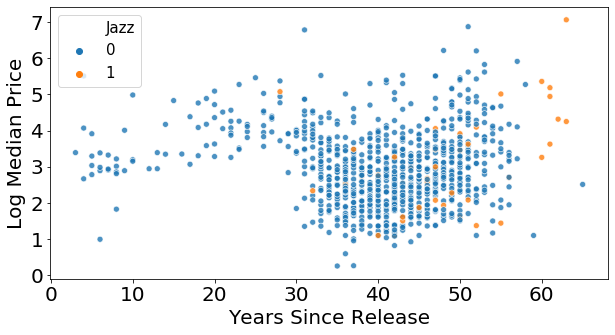

In [429]:
plt.figure(figsize=(10,5))
sns.scatterplot(df['years_since_release'],df['log_median_price'],alpha=0.8, hue=df['Jazz'])

plt.xlabel('Years Since Release', fontsize=20)
plt.ylabel('Log Median Price', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15);

plt.savefig('Jazz Years.tiff')

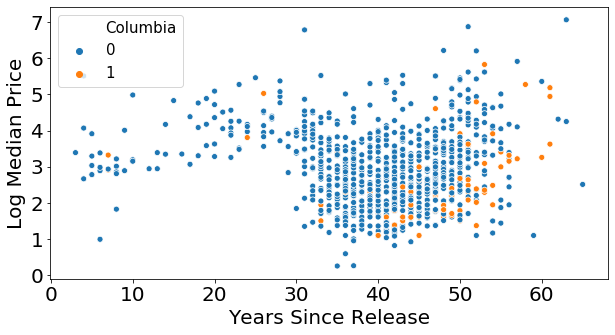

In [431]:
plt.figure(figsize=(10,5))
sns.scatterplot(df['years_since_release'],df['log_median_price'],hue=df['Columbia'])


plt.xlabel('Years Since Release', fontsize=20)
plt.ylabel('Log Median Price', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15);

plt.savefig('Columbia Years.tiff')

### Country dummies
I created country of album release dummy variables, and selected a few more common ones to keep.

In [203]:
country = pd.get_dummies(df['release_country'])

In [204]:
country.head()

,Australia,Australia & New Zealand,Canada,Europe,France,Germany,Italy,Japan,Netherlands,Sweden,UK,UK & Europe,UK & Ireland,"UK, Europe & US",US,USA & Canada,USA & Europe
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [205]:
df['release_country'].value_counts().head(10)

US                 472
UK                 410
Europe              40
UK & Europe         17
Australia           13
Canada              13
Germany             11
Sweden               7
France               4
UK, Europe & US      4
Name: release_country, dtype: int64

In [206]:
country = country[['US','UK','Europe','UK & Europe','Canada','Australia','Germany']]

I also created an artists dummy variable and kept the top 10 artists as variables

In [207]:
artist = pd.get_dummies(df['artists'])

In [208]:
df['artists'].value_counts().head(10)

The Beatles           24
Pink Floyd            20
David Bowie           19
Bob Dylan             19
The Rolling Stones    18
Genesis               14
Depeche Mode          14
Queen                 14
AC/DC                 12
Black Sabbath         11
Name: artists, dtype: int64

In [209]:
top_artists=list(df['artists'].value_counts().head(10).index)

In [210]:
artist = artist[top_artists]

In [211]:
artist

,The Beatles,Pink Floyd,David Bowie,Bob Dylan,The Rolling Stones,Genesis,Depeche Mode,Queen,AC/DC,Black Sabbath
0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0
998,0,0,1,0,0,0,0,0,0,0


### Label Dummies
I did the same for the record labels variable

In [212]:
label = pd.get_dummies(df['label'])

In [213]:
label.columns

Index(['20th Century Records', '4AD', 'A&M Records', 'ABC Records',
       'ABC/Dunhill Records', 'ARC (3)', 'ATCO Records',
       'Aftermath Entertainment', 'Albert Productions', 'Anthem (5)',
       ...
       'WWA Records', 'Warner Bros. - Seven Arts Records',
       'Warner Bros. Records', 'Warp Records', 'Westbound Records',
       'Wilbury Records', 'Wild Bunch Records', 'XL Recordings', 'ZTT',
       'Zappa Records'],
      dtype='object', length=184)

In [214]:
df['label'].value_counts().head(10)

Columbia                90
Warner Bros. Records    48
Island Records          40
EMI                     37
Atlantic                30
Elektra                 29
Epic                    26
Capitol Records         26
A&M Records             25
Vertigo                 21
Name: label, dtype: int64

In [215]:
top_labels=list(df['label'].value_counts().head(10).index)
top_labels

['Columbia',
 'Warner Bros. Records',
 'Island Records',
 'EMI',
 'Atlantic',
 'Elektra',
 'Epic',
 'Capitol Records',
 'A&M Records',
 'Vertigo']

In [216]:
label = label[top_labels]

In [217]:
pd.concat([df,label,country,artist],axis=1).shape

(1000, 62)

In [218]:
df=pd.concat([df,label,country,artist],axis=1)

Saving an updated version of the data frame

In [223]:
import pickle
with open('feature_engineering_df_2.pickle', 'wb') as write_file:
    pickle.dump(df, write_file)

In [604]:
import pickle
with open('feature_engineering_df_2.pickle', 'rb') as read_file:
    df=pickle.load(read_file)

In [219]:
df.shape

(1000, 62)

Drop some columns that were replaced by dummies, were not meant to be analyzed or I no longer want in the analysis

In [220]:

df.drop(['top_artists_spotify_name','top_artists_orig_name'],axis=1, inplace=True)

In [221]:
df.drop(['label','release_country','index','styles','genres'],axis=1, inplace=True)

In [222]:
df.drop(['users_have', 'users_want', 'number_for_sale', 'log_time_since_sold'], axis=1, inplace=True)

## Train/test split

In [224]:
from sklearn.model_selection import train_test_split

In [225]:
df.dropna(how='any',axis=0,inplace=True)

In [226]:
df.shape

(983, 51)

The train test split with an 80-20 split. This 20% of the data in the test split I should NOT use to create my model in any way.

In [227]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'log_median_price'], df['log_median_price'], test_size=0.2, random_state=111, stratify=df[['US','UK','Europe','UK & Europe','Canada','Australia','Germany']])

In [228]:
X_train.iloc[:,2:].head()

,number_of_songs,user_rating,versions,spotify_monthly_listeners,years_after_first_album,years_since_any_album,years_since_release,less_than_30_year_old,more_than_30_year_old,Classic_Rock,...,The Beatles,Pink Floyd,David Bowie,Bob Dylan,The Rolling Stones,Genesis,Depeche Mode,Queen,AC/DC,Black Sabbath
589,14.0,4.31,155.0,13960826.0,8.0,0.0,42.0,False,True,0,...,0,0,0,0,0,0,0,0,0,0
339,12.0,4.24,224.0,9221287.0,0.0,8.0,49.0,False,True,0,...,0,0,0,0,0,0,0,0,0,0
612,8.0,4.27,147.0,2979305.0,3.0,0.0,50.0,False,True,1,...,0,0,0,0,0,0,0,0,0,0
822,9.0,4.11,107.0,2280677.0,1.0,1.0,39.0,False,True,0,...,0,0,0,0,0,0,0,0,0,0
8,30.0,4.58,656.0,22982890.0,5.0,2.0,52.0,False,True,0,...,1,0,0,0,0,0,0,0,0,0


## Exploration of polynomial and interaction variables

Working with training data, I explored polynomial and interaction variables since I noticed they may be present in data visualization above. I used a naive approach to identify terms that may have predictive power, by creating all possible terms and then creating a model with statsmodel OLS. I looked at the terms with coefficients that had low p-value and graphed them to find interesting ones.

I could have also done a Lasso regression and looked at the highest value coefficients from that regression, but I did it this way originally. I like the idea of using the p-value, because sometimes a coefficent can be large but it's estimate has high variance so it is might not be different from 0. Lasso might change those coefficients to 0, but I'm not sure. 

In [229]:
from sklearn.preprocessing import PolynomialFeatures

In [230]:
p = PolynomialFeatures()
X_train_poly = p.fit_transform(X_train.iloc[:,2:])

Linear model with continuous features from statsmodel

In [231]:
import statsmodels.api as sm

In [232]:
import numpy as np

In [233]:
Y_sm = np.array(y_train)
X_sm = X_train_poly

In [234]:
model = sm.OLS(Y_sm, sm.add_constant(X_sm)) 

In [235]:
fit = model.fit()

In [139]:
#fit.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     37.19
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          1.17e-195
Time:                        15:24:49   Log-Likelihood:                -535.59
No. Observations:                 786   AIC:                             1217.
Df Residuals:                     713   BIC:                             1558.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.003     -0.806      0.420      -0.007       0.003
x1             0.0361      0.028      1.271      0.204      -0.020       0.092
x2            -0.0099      0.016     -0.633      0.527      -0.041       0.021
x3             0.0138      0.006      2.204      0.028       0.002       0.026
x4             0.0054      0.005      1.015      0.310      -0.005       0.016
x5          1.252e-07   9.34e-08      1.341      0.180   -5.81e-08    3.09e-07
x6             0.0166      0.016      1.030      0.303      -0.015       0.048
x7            -0.0230      0.018     -1.264      0.206      -0.059       0.013
x8            -0.1357      0.023     -5.810      0.000      -0.182      -0.090
x9             0.0015      0.002      0.782      0.434      -0.002       0.005
x10           -0.0022      0.001     -1.702      0.089      -0.005       0.000
x11            0.0027      0.004      0.747      0.456      -0.004       0.010
x12           -0.0004      0.001     -0.256      0.798      -0.003       0.003
x13           -0.0086      0.004     -2.100      0.036      -0.017      -0.001
x14           -0.0011      0.001     -1.233      0.218      -0.003       0.001
x15            0.0102      0.004      2.536      0.011       0.002       0.018
x16           -0.0043      0.002     -1.999      0.046      -0.009   -7.65e-05
x17           -0.0027      0.001     -2.962      0.003      -0.005      -0.001
x18           -0.0040      0.003     -1.238      0.216      -0.010       0.002
x19           -0.0017      0.001     -1.458      0.145      -0.004       0.001
x20            0.0021      0.003      0.672      0.502      -0.004       0.008
x21            0.0002      0.001      0.183      0.855      -0.002       0.003
x22           -0.0056      0.002     -2.743      0.006      -0.010      -0.002
x23            0.0007      0.001      0.574      0.566      -0.002       0.003
x24           -0.0003      0.002     -0.197      0.844      -0.004       0.003
x25            0.0026      0.001      3.307      0.001       0.001       0.004
x26           -0.0010      0.003     -0.298      0.766      -0.008       0.006
x27            0.0011      0.001      1.337      0.182      -0.001       0.003
x28            0.0003      0.001      0.315      0.753      -0.002       0.002
x29            0.0024      0.001      1.886      0.060   -9.59e-05       0.005
x30            0.0024      0.003      0.927      0.354      -0.003       0.007
x31            0.0030      0.001      4.617      0.000       0.002       0.004
x32            0.0022      0.001      2.048      0.041     9.3e-05       0.004
x33            0.0003      0.001      0.394      0.694      -0.001       0.002
x34            0.0164      0.006      2.699      0.007       0.004       0.028
x35           -0.0186      0.006     -3.069      0.002      -0.031      -0.007
x3

In [236]:
X_train_poly.shape

(786, 1225)

In [237]:
poly_features_names = p.get_feature_names(X_train.iloc[:,2:].columns)

In [238]:
highly_sig_poly_features = [i for i in range(len(fit.pvalues)) if fit.pvalues[i] < 0.01]

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [239]:
[poly_features_names[i] for i in highly_sig_poly_features]

['spotify_monthly_listeners',
 'years_since_release',
 'more_than_30_year_old',
 'Classic_Rock',
 'Heavy_Metal',
 'Pink Floyd',
 'Queen',
 'number_of_songs Black Sabbath',
 'user_rating^2',
 'user_rating years_since_release',
 'user_rating Classic_Rock',
 'user_rating Heavy_Metal',
 'user_rating A&M Records',
 'user_rating Australia',
 'user_rating Genesis',
 'user_rating Black Sabbath',
 'versions spotify_monthly_listeners',
 'versions years_after_first_album',
 'versions years_since_release',
 'versions UK & Europe',
 'spotify_monthly_listeners less_than_30_year_old',
 'spotify_monthly_listeners more_than_30_year_old',
 'spotify_monthly_listeners Folk',
 'spotify_monthly_listeners Island Records',
 'spotify_monthly_listeners David Bowie',
 'spotify_monthly_listeners Depeche Mode',
 'years_after_first_album Jazz',
 'years_after_first_album Funk',
 'years_after_first_album A&M Records',
 'years_after_first_album Black Sabbath',
 'years_since_any_album Columbia',
 'years_since_release^2

Some squared terms were suggested from this model:

In [144]:
X_train["user_rating**2"]= X_train["user_rating"]**2
X_train['years_since_release**2'] = X_train['years_since_release']**2
X_test['user_rating**2']=X_test['user_rating']**2
X_test['years_since_release**2'] = X_test['years_since_release']**2

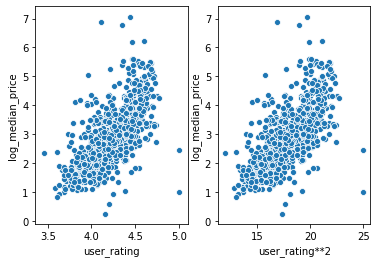

In [147]:
plt.rcParams['font.size'] = 10
fig, axes = plt.subplots(1,2)
sns.scatterplot(ax=axes[0], x=X_train['user_rating'],y=y_train)
sns.scatterplot(ax= axes[1], x=X_train['user_rating**2'],y=y_train)

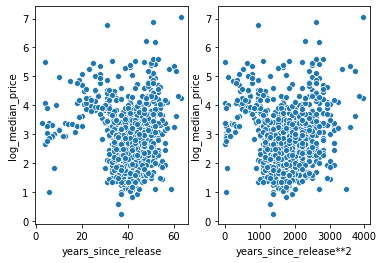

In [148]:
fig, axes = plt.subplots(1,2)
sns.scatterplot(ax=axes[0], x=X_train['years_since_release'],y=y_train)
sns.scatterplot(ax= axes[1], x=X_train['years_since_release**2'],y=y_train)

### Here I plotted some interaction terms and added to my data frame. Some were from the OLS coefficients with low p-values and some were from guessing by domain knowledge.

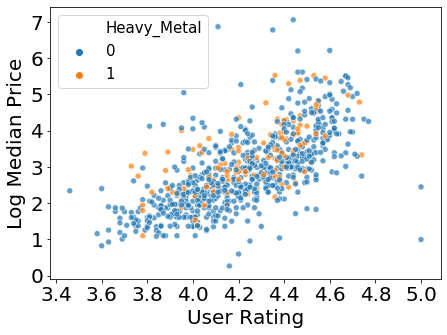

In [426]:
plt.figure(figsize=(7,5))
sns.scatterplot(X_train['user_rating'],y_train, hue=df['Heavy_Metal'], alpha=0.7)

plt.xlabel('User Rating', fontsize=20)
plt.ylabel('Log Median Price', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15);

plt.savefig('Heavy Metal Rating.tiff')

In [304]:
X_train['user_rating*HeavyMetal']=X_train['user_rating']*X_train['Heavy_Metal']
X_test['user_rating*HeavyMetal']=X_test['user_rating']*X_test['Heavy_Metal']

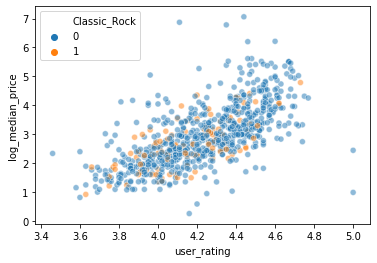

In [255]:
sns.scatterplot(X_train['user_rating'],y_train, hue=df['Classic_Rock'], alpha=0.5)

In [305]:
X_train['user_rating*ClassicRock']=X_train['user_rating']*X_train['Classic_Rock']
X_test['user_rating*ClassicRock']=X_test['user_rating']*X_test['Classic_Rock']

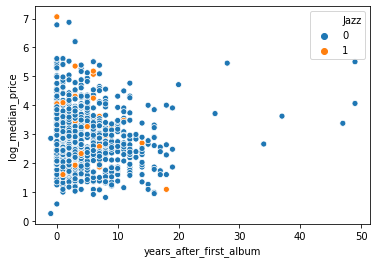

In [240]:
sns.scatterplot(X_train['years_after_first_album'],y_train, hue=df['Jazz'])

In [306]:
X_train['years_after_first*Jazz']=X_train['years_after_first_album']*X_train['Jazz']
X_test['years_after_first*Jazz']=X_test['years_after_first_album']*X_test['Jazz']

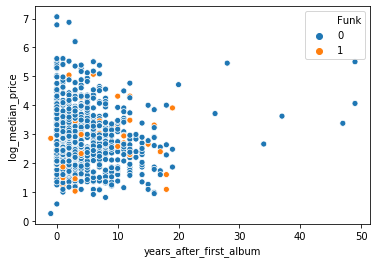

In [241]:
sns.scatterplot(X_train['years_after_first_album'],y_train, hue=df['Funk'])

In [307]:
X_train['years_after_first*Funk']=X_train['years_after_first_album']*X_train['Funk']
X_test['years_after_first*Funk']=X_test['years_after_first_album']*X_test['Funk']

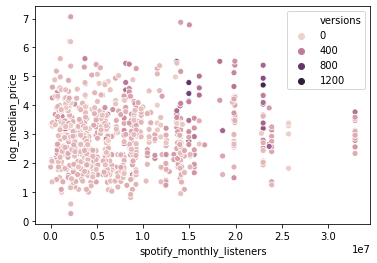

In [244]:
sns.scatterplot(X_train['spotify_monthly_listeners'],y_train, hue=df['versions'])

In [310]:
X_train['spotify*versions']=X_train['spotify_monthly_listeners']*X_train['versions']
X_test['spotify*versions']=X_test['spotify_monthly_listeners']*X_test['versions']

In [437]:
import matplotlib.ticker as tick

In [445]:
X_train['spotify_monthly_listeners'].describe()

count    7.860000e+02
mean     8.499256e+06
std      6.796004e+06
min      2.195000e+03
25%      3.523266e+06
50%      6.463686e+06
75%      1.248226e+07
max      3.292538e+07
Name: spotify_monthly_listeners, dtype: float64

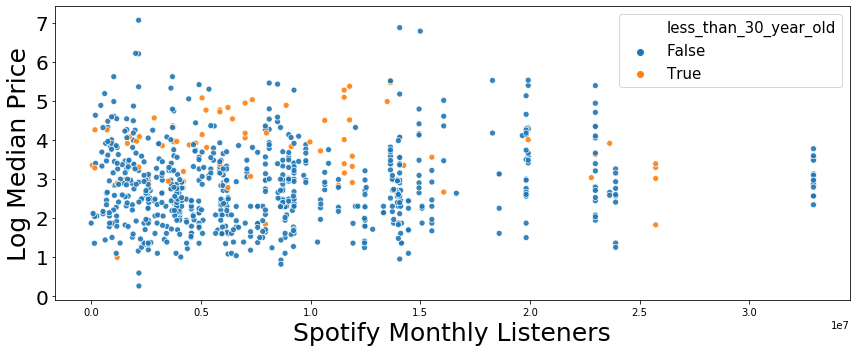

In [922]:
plt.figure(figsize=(12,5))
sns.scatterplot(X_train_orig['spotify_monthly_listeners'],Y_train_orig, alpha=0.9, hue=X_train_orig['less_than_30_year_old'])

plt.xlabel('Spotify Monthly Listeners', fontsize=25)
plt.ylabel('Log Median Price', fontsize=25)
#plt.xticks(fontsize=20, ticks=[0, 5000000, 10000000, 15000000, 20000000,  25000000, 30000000], labels=['0','5M','10M','15M','20M','25M','30M'])
plt.yticks(fontsize=20)
plt.legend(fontsize=15);
plt.tight_layout()

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.savefig('Spotify Age.tiff')



In [312]:
X_train['spotify*30year']=X_train['spotify_monthly_listeners']*X_train['more_than_30_year_old']
X_test['spotify*30year']=X_test['spotify_monthly_listeners']*X_test['more_than_30_year_old']

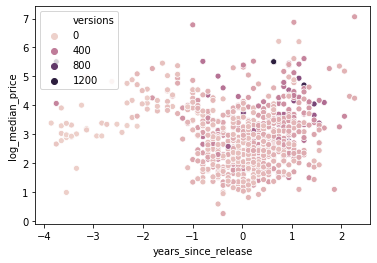

In [511]:
sns.scatterplot(X_train['years_since_release'],y_train, hue=df['versions'])

In [313]:
X_train['years_since_release*versions']=X_train['years_since_release']*X_train['versions']
X_test['years_since_release*versions']=X_test['years_since_release']*X_test['versions']

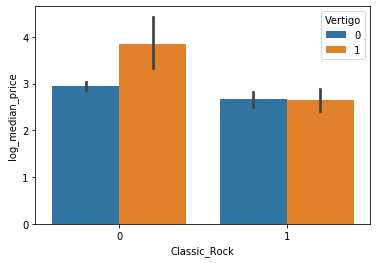

In [267]:

sns.barplot(X_train['Classic_Rock'],y_train, hue=df['Vertigo'])

In [314]:
X_train['Classic_Rock*Vertigo'] = X_train['Classic_Rock']*X_train['Vertigo']
X_test['Classic_Rock*Vertigo'] = X_test['Classic_Rock']*X_test['Vertigo']

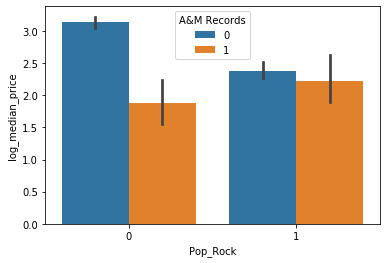

In [315]:
sns.barplot(X_train['Pop_Rock'],y_train, hue=df['A&M Records'])

In [316]:
X_train['Pop_Rock*A&M'] = X_train['Pop_Rock']*X_train['A&M Records']
X_test['Pop_Rock*A&M'] = X_test['Pop_Rock']*X_test['A&M Records']

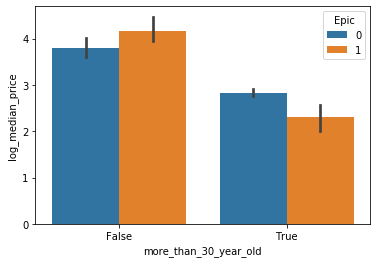

In [317]:
sns.barplot(X_train['more_than_30_year_old'],y_train, hue=df['Epic'])

In [318]:
X_train['more_than_30*Epic']=X_train['more_than_30_year_old']*X_train['Epic']
X_test['more_than_30*Epic']=X_test['more_than_30_year_old']*X_test['Epic']

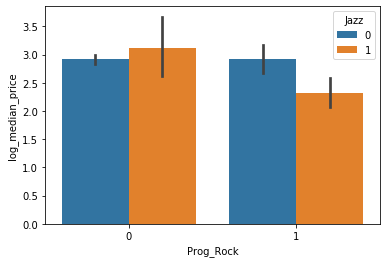

In [319]:
sns.barplot(X_train['Prog_Rock'],y_train, hue=df['Jazz'])

In [320]:
X_train['Prog_Rock*Jazz']=X_train['Prog_Rock']*X_train['Jazz']
X_test['Prog_Rock*Jazz']=X_test['Prog_Rock']*X_test['Jazz']

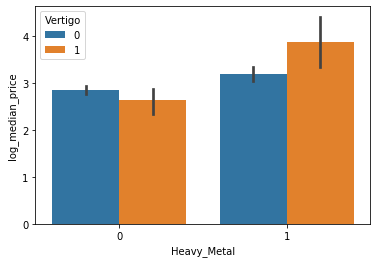

In [322]:
sns.barplot(X_train['Heavy_Metal'],y_train, hue=df['Vertigo'])

In [323]:
X_train['Heavy_Metal*Vertigo']=X_train["Heavy_Metal"]*X_train["Vertigo"]
X_test['Heavy_Metal*Vertigo']=X_test["Heavy_Metal"]*X_test["Vertigo"]

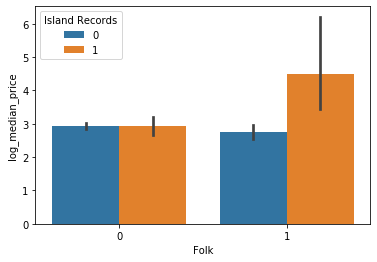

In [324]:
sns.barplot(X_train['Folk'],y_train, hue=df['Island Records'])

In [325]:
X_train['Folk*Island_Records']=X_train['Folk']*X_train['Island Records']
X_test['Folk*Island_Records']=X_test['Folk']*X_test['Island Records']

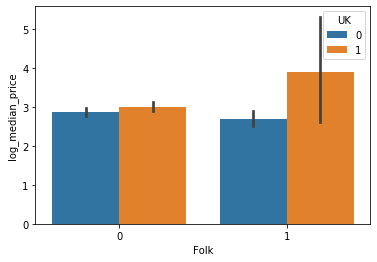

In [326]:
sns.barplot(X_train['Folk'],y_train, hue=df['UK'])

In [327]:
X_train['Folk*UK']=X_train['Folk']*X_train["UK"]
X_test['Folk*UK']=X_test['Folk']*X_test["UK"]

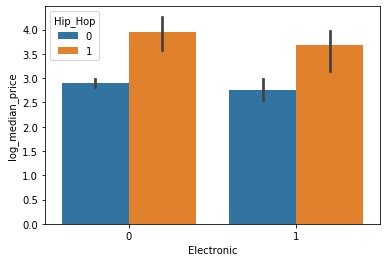

In [328]:
sns.barplot(X_train['Electronic'],y_train, hue=df['Hip_Hop'])

In [329]:
X_train['Hip_Hop*Electronic']=X_train["Hip_Hop"]*X_train["Electronic"]
X_test['Hip_Hop*Electronic']=X_test["Hip_Hop"]*X_test["Electronic"]

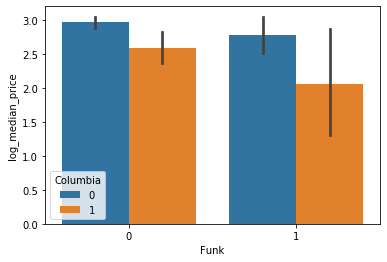

In [330]:
sns.barplot(X_train['Funk'],y_train, hue=df['Columbia'])

In [331]:
X_train['Funk*Columbia']=X_train['Funk']*X_train["Columbia"]
X_test['Funk*Columbia']=X_test['Funk']*X_test["Columbia"]

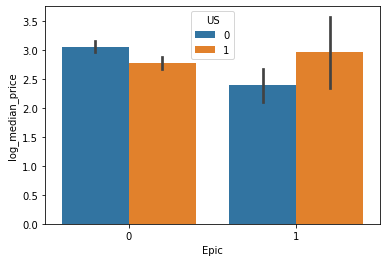

In [332]:
sns.barplot(X_train['Epic'],y_train, hue=df['US'])

In [333]:
X_train['Epic*US'] = X_train['Epic'] * X_train['US']
X_test['Epic*US'] = X_test['Epic'] * X_test['US']

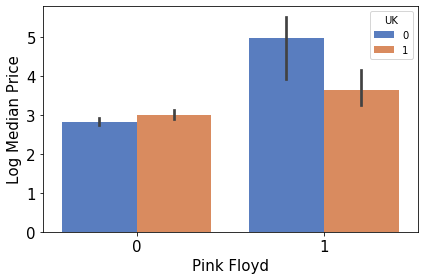

In [533]:
sns.barplot(X_train_orig['Pink Floyd'],Y_train_orig, hue=df['UK'],palette='muted')
       
plt.xlabel('Pink Floyd', fontsize=15)
plt.ylabel('Log Median Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('PinkFloydUK.tiff')

In [335]:
X_train['PinkFloyd*UK']=X_train["Pink Floyd"]*X_train["UK"]
X_test['PinkFloyd*UK']=X_test["Pink Floyd"]*X_test["UK"]

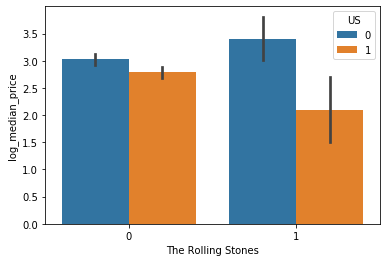

In [336]:
sns.barplot(X_train['The Rolling Stones'],y_train, hue=df['US'])

In [337]:
X_train['RollingStones*US']=X_train["The Rolling Stones"] * X_train['US']
X_test['RollingStones*US']=X_test["The Rolling Stones"] * X_test['US']

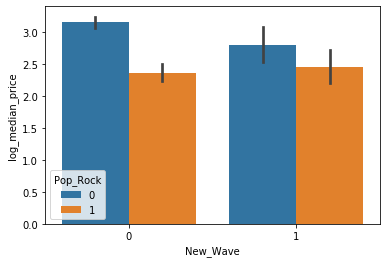

In [339]:
sns.barplot(X_train['New_Wave'],y_train, hue=df['Pop_Rock'])

In [345]:
X_train['New_Wave*Pop']=X_train['New_Wave']*X_train['Pop_Rock']
X_test['New_Wave*Pop']=X_test['New_Wave']*X_test['Pop_Rock']

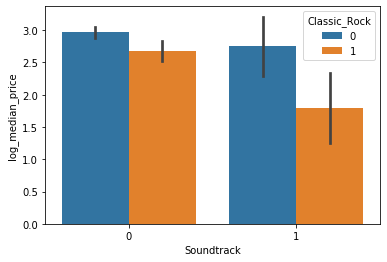

In [346]:
sns.barplot(X_train['Soundtrack'],y_train, hue=df['Classic_Rock'])

In [347]:
X_train['Soundrack*ClassicRock']=X_train["Soundtrack"]*X_train["Classic_Rock"]
X_test['Soundtrack*ClassicRock']=X_test["Soundtrack"]*X_test["Classic_Rock"]

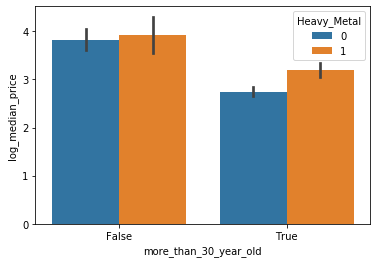

In [352]:
sns.barplot(X_train['more_than_30_year_old'],y_train, hue=df['Heavy_Metal'])

In [353]:
X_train['more_than_30*HeavyMetal']=X_train['more_than_30_year_old']*X_train["Heavy_Metal"]
X_test['more_than_30*HeavyMetal']=X_test['more_than_30_year_old']*X_test["Heavy_Metal"]

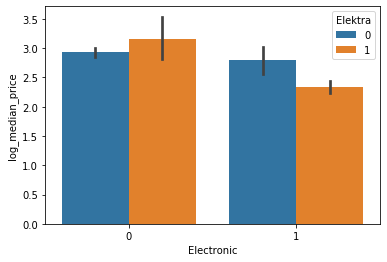

In [361]:
sns.barplot(X_train['Electronic'],y_train, hue=df['Elektra'])

In [362]:
X_train['Electronic*Elektra']=X_train['Electronic']*X_train["Elektra"]
X_test['Electronic*Elektra']=X_test['Electronic']*X_test["Elektra"]

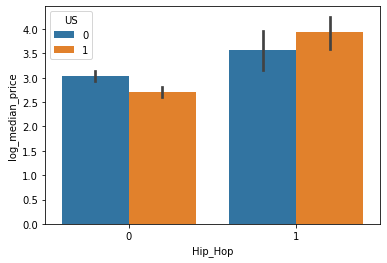

In [371]:
sns.barplot(X_train['Hip_Hop'],y_train, hue=df['US'])

In [372]:
X_train['Hip_Hop*US']=X_train['Hip_Hop']*X_train["US"]
X_test['Hip_Hop*US']=X_test['Hip_Hop']*X_test["US"]

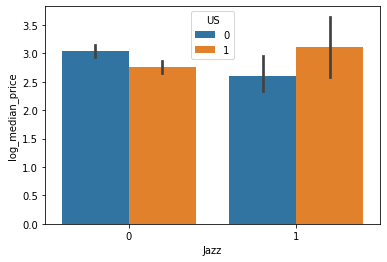

In [373]:
sns.barplot(X_train['Jazz'],y_train, hue=df['US'])

In [374]:
X_train['Jazz*US']=X_train['Jazz']*X_train["US"]
X_test['Jazz*US']=X_test['Jazz']*X_test["US"]

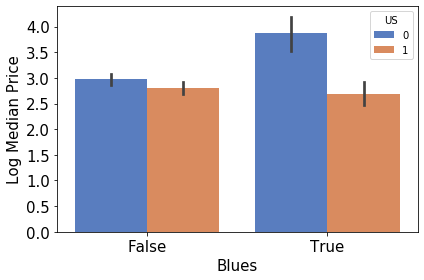

In [530]:

sns.barplot(X_train_orig['Blues'],Y_train_orig, hue=df['US'], palette="muted")
           
plt.xlabel('Blues', fontsize=15)
plt.ylabel('Log Median Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('BluesUS.tiff')

In [376]:
X_train['Blues*US']=X_train['Blues']*X_train["US"]
X_test['Blues*US']=X_test['Blues']*X_test["US"]



Excluding some of the others because they apply only to a small number of samples

In [381]:
X_train.columns

Index(['artists', 'albums', 'number_of_songs', 'user_rating', 'versions',
       'spotify_monthly_listeners', 'years_after_first_album',
       'years_since_any_album', 'years_since_release', 'less_than_30_year_old',
       'more_than_30_year_old', 'Classic_Rock', 'Pop_Rock', 'Prog_Rock',
       'Heavy_Metal', 'Folk', 'New_Wave', 'Electronic', 'Hip_Hop', 'Blues',
       'Jazz', 'Funk', 'Soundtrack', 'Columbia', 'Warner Bros. Records',
       'Island Records', 'EMI', 'Atlantic', 'Elektra', 'Epic',
       'Capitol Records', 'A&M Records', 'Vertigo', 'US', 'UK', 'Europe',
       'UK & Europe', 'Canada', 'Australia', 'Germany', 'The Beatles',
       'Pink Floyd', 'David Bowie', 'Bob Dylan', 'The Rolling Stones',
       'Genesis', 'Depeche Mode', 'Queen', 'AC/DC', 'Black Sabbath',
       'user_rating*HeavyMetal', 'user_rating*ClassicRock',
       'years_after_first*Jazz', 'years_after_first*Funk', 'spotify*versions',
       'spotify*30year', 'years_since_release*versions',
       'Classic_R

In [382]:
X_train.iloc[:,2:].shape

(786, 74)

In [383]:
X_train=X_train.reindex()
y_train=y_train.reindex()

### First linear model in sklearn, testing score by cross-validation

In [384]:
from sklearn.model_selection import KFold

In [385]:
from sklearn.linear_model import LinearRegression

In [386]:
kf = KFold(n_splits=10, shuffle=True)

cv_lm_r2s = [] 
cv_lm_MSEs = []

for train_ind, val_ind in kf.split(X_train,y_train):
    #print(train_ind)
    X_train_cv, y_train_cv = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    #print(X_train_cv.shape)
    #print(X_val.shape)
    #print(y_train_cv.shape)
    #print(y_val.shape)
    #simple linear regression
    lm = LinearRegression()
    
    #y_train_cv=np.array(y_train_cv).reshape(-1,1)
    #y_val=np.array(y_val).reshape(-1,1)

    lm.fit(X_train_cv.iloc[:,2:], y_train_cv)
    cv_lm_r2s.append((lm.score(X_train_cv.iloc[:,2:], y_train_cv),lm.score(X_val.iloc[:,2:], y_val)))
    cv_lm_MSEs.append((np.sum((lm.predict(X_train_cv.iloc[:,2:]) - y_train_cv)**2) / len(y_train_cv),np.sum((lm.predict(X_val.iloc[:,2:]) - y_val)**2) / len(y_val)))

In [387]:
cv_lm_r2s

[(0.655719640705875, 0.3939546923446592),
 (0.6374889549981595, 0.6640378516001557),
 (0.6386163596736038, 0.6507373719509582),
 (0.6635145845120026, 0.36658621328837504),
 (0.6374114113358795, 0.6533638377133172),
 (0.650893812311803, 0.49143573709674665),
 (0.6523971531560496, 0.4840899784362741),
 (0.6559429629381945, 0.4371431212329569),
 (0.6474886223545548, 0.4948653754818201),
 (0.6344476816938005, 0.6620304804510974)]

In [388]:
cv_lm_MSEs

[(0.37616726848476556, 0.632934457712736),
 (0.40214661417885567, 0.29679233391970544),
 (0.38796796812651385, 0.42389758870523386),
 (0.37090152237816926, 0.6028193047869408),
 (0.3933084450239421, 0.38633968596544943),
 (0.38579966518222, 0.47440447827291216),
 (0.3791800619555518, 0.5357439759311451),
 (0.3733808494886718, 0.622641866348399),
 (0.37708428804951966, 0.6192078597065629),
 (0.38884847589284083, 0.4377890653680595)]

In [496]:
np.mean([cv_lm_MSEs[i][1] for i in range(10)])

0.5032570616717145

In [493]:
cv_lm_r2s[][0]

(0.655719640705875, 0.3939546923446592)

The first column of training set R^2 is usually higher than the test set R^2. It may be overfit, and I should use Lasso or Ridge to increase fitting on test sets

In [390]:
y_val.shape

(78,)

In [391]:
X_val.shape

(78, 76)

In [392]:
y_train_cv.shape

(708,)

In [393]:
X_train_cv.shape

(708, 76)

In [452]:
X_train_orig=X_train.copy()
Y_train_orig=y_train.copy()
X_test_orig=X_test.copy()
Y_test_orgi=y_test.copy()

### Scaling 

While variables do not need to be scaled for stanard linear regression, the penalities from Lasso and Ridge regression will not be able to be applied evenly on non-scaled variables. For Lasso and Ridge to perform optimally, I am going to scale my variables with StandardScaler (Z-score transformation).

In [453]:
from sklearn.preprocessing import StandardScaler

I need to scale the categorical varialbes as well, so the variables with more 1's don't have more weight in the penalty score from Lasso or Ridge. Since I am including categorical variables, I used with_mean=False)

In [454]:
scaler = StandardScaler()
X_train.iloc[:,2:] = scaler.fit_transform(X_train.iloc[:,2:])
X_test.iloc[:,2:] = scaler.fit_transform(X_test.iloc[:,2:])

In [455]:
X_train.describe()

,number_of_songs,user_rating,versions,spotify_monthly_listeners,years_after_first_album,years_since_any_album,years_since_release,less_than_30_year_old,more_than_30_year_old,Classic_Rock,...,Epic*US,PinkFloyd*UK,RollingStones*US,New_Wave*Pop,Soundrack*ClassicRock,more_than_30*HeavyMetal,Electronic*Elektra,Hip_Hop*US,Jazz*US,Blues*US
count,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,...,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02
mean,7.062487e-20,-9.840870e-16,-8.785734e-17,9.604983e-18,-6.394862e-17,-2.033996e-17,-2.811223e-16,2.428083e-16,-3.117382e-16,-2.618770e-16,...,-1.454872e-16,-1.519494e-16,1.261360e-16,1.356704e-16,4.029855e-16,-2.018459e-16,2.543908e-16,-5.176803e-17,5.996052e-17,1.824947e-16
std,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,...,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00
min,-2.441566e+00,-2.979367e+00,-1.487483e+00,-1.251099e+00,-1.128277e+00,-5.346567e-01,-3.850586e+00,-3.247849e-01,-3.078961e+00,-3.991141e-01,...,-1.296827e-01,-1.135192e-01,-5.050763e-02,-1.530931e-01,-5.050763e-02,-4.389946e-01,-5.050763e-02,-1.736208e-01,-1.886084e-01,-2.578483e-01
25%,-4.595667e-01,-7.537091e-01,-5.696387e-01,-7.326597e-01,-7.560522e-01,-5.346567e-01,-4.857015e-01,-3.247849e-01,3.247849e-01,-3.991141e-01,...,-1.296827e-01,-1.135192e-01,-5.050763e-02,-1.530931e-01,-5.050763e-02,-4.389946e-01,-5.050763e-02,-1.736208e-01,-1.886084e-01,-2.578483e-01
50%,-2.118168e-01,2.722335e-02,-2.459346e-01,-2.997153e-01,-1.977149e-01,-3.981708e-01,1.260956e-01,-3.247849e-01,3.247849e-01,-3.991141e-01,...,-1.296827e-01,-1.135192e-01,-5.050763e-02,-1.530931e-01,-5.050763e-02,-4.389946e-01,-5.050763e-02,-1.736208e-01,-1.886084e-01,-2.578483e-01
75%,2.836832e-01,7.691092e-01,3.133768e-01,5.864543e-01,3.606225e-01,1.128700e-02,6.359265e-01,-3.247849e-01,3.247849e-01,-3.991141e-01,...,-1.296827e-01,-1.135192e-01,-5.050763e-02,-1.530931e-01,-5.050763e-02,-4.389946e-01,-5.050763e-02,-1.736208e-01,-1.886084e-01,-2.578483e-01
max,7.220682e+00,3.033813e+00,6.592826e+00,3.596478e+00,8.177345e+00,6.426125e+00,2.267385e+00,3.078961e+00,3.247849e-01,2.505549e+00,...,7.711131e+00,8.809086e+00,1.979899e+01,6.531973e+00,1.979899e+01,2.277932e+00,1.979899e+01,5.759680e+00,5.301991e+00,3.878249e+00


### Lasso and Ridge with cross validation for identifying optimal alpha

In [456]:
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge

LassoCV with 5 folds, to identify best alpha

In [540]:

lm = LassoCV(cv=10, n_alphas=1000, max_iter=5000)

lm.fit(X_train.iloc[:,2:],y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=5000, n_alphas=1000, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [541]:
lm.score(X_train.iloc[:,2:], y_train)

0.6362104668317545

In [459]:
lm.score(X_test.iloc[:,2:], y_test)

0.4825181617869142

In [460]:
np.sum((lm.predict(X_train.iloc[:,2:]) - y_train)**2) / len(y_train)

0.39573075870676216

In [461]:
np.sum((lm.predict(X_test.iloc[:,2:]) - y_test)**2) / len(y_test)

0.5213847547686828

In [462]:
lasso_coef= lm.coef_

In [463]:
lasso_alpha=lm.alpha_
lasso_alpha

0.003778147473025964

In [464]:
kf = KFold(n_splits=10, shuffle=True, random_state = 71)

cv_lasso_r2s = [] 
cv_lasso_MSEs = []

for train_ind, val_ind in kf.split(X_train,y_train):
    #print(train_ind)
    X_train_cv, y_train_cv = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    #print(X_train_cv.shape)
    #print(X_val.shape)
    #print(y_train_cv.shape)
    #print(y_val.shape)
    #simple linear regression
    lm = Lasso(alpha=lasso_alpha, max_iter=5000)
    
    #y_train_cv=np.array(y_train_cv).reshape(-1,1)
    #y_val=np.array(y_val).reshape(-1,1)

    lm.fit(X_train_cv.iloc[:,2:], y_train_cv)
    
    predictions=lm.predict(X_train_cv.iloc[:,2:])
    train_MSE=np.sum((predictions - y_train_cv)**2)/len(y_train_cv)
    
    val_predictions=lm.predict(X_val.iloc[:,2:])
    validation_MSE = np.sum((val_predictions - y_val)**2)/len(y_val)
    
    cv_lasso_r2s.append((lm.score(X_train_cv.iloc[:,2:], y_train_cv),lm.score(X_val.iloc[:,2:], y_val)))
    cv_lasso_MSEs.append((train_MSE, validation_MSE))

In [465]:
cv_lasso_r2s

[(0.6431285235938754, 0.5515513716806233),
 (0.6393109768519489, 0.5534629984556162),
 (0.6518437128335357, 0.4676503028019071),
 (0.639647666025168, 0.5425317722271473),
 (0.6327042123919013, 0.6240549856489637),
 (0.6321079651362129, 0.6392498206861716),
 (0.6376223419007458, 0.5165885674901187),
 (0.6251362382314509, 0.7443238231234255),
 (0.6640367045073526, 0.3075816117091644),
 (0.6418699647022735, 0.5622457924149298)]

In [466]:
cv_lasso_MSEs

[(0.3864978699331562, 0.5069545864069631),
 (0.3964987867078794, 0.4300127086692218),
 (0.37627541026155686, 0.6097564769059315),
 (0.3940866280821334, 0.46833909864660805),
 (0.3983575914590319, 0.41872102636748837),
 (0.4107811921435283, 0.2968833222762044),
 (0.38678644426400216, 0.5971417462105116),
 (0.4140530783071616, 0.2392307979522239),
 (0.3626559727201282, 0.8035939071004019),
 (0.38243176757213976, 0.5550382781582491)]

In [467]:
np.sqrt(np.array(cv_lasso_MSEs))

array([[0.62168953, 0.71200743],
       [0.6296815 , 0.65575354],
       [0.61341292, 0.78086905],
       [0.62776319, 0.68435305],
       [0.63115576, 0.64708657],
       [0.64092214, 0.54487   ],
       [0.62192157, 0.77274947],
       [0.64346956, 0.48911225],
       [0.60220924, 0.89643399],
       [0.61841068, 0.74500891]])

In [497]:
np.mean([cv_lasso_MSEs[i][1] for i in range(10)])

0.4925671948693804

RidgeCV with 5 folds

In [474]:
lm = RidgeCV(cv=10, alphas=(np.arange(0,2,0.001)))

lm.fit(X_train.iloc[:,2:],y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.58519e-18): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.45697e-18): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.34577e-18): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.57232e-36): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.2466e-17): result may not be accurate.
  overwrite_a=True).T


RidgeCV(alphas=array([0.000e+00, 1.000e-03, 2.000e-03, ..., 1.997e+00, 1.998e+00,
       1.999e+00]),
        cv=10, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [475]:
lm.score(X_train.iloc[:,2:], y_train)

0.6417682584751433

In [476]:
lm.score(X_test.iloc[:,2:], y_test)

0.4685424415802566

In [477]:
np.sum((lm.predict(X_train.iloc[:,2:]) - y_train)**2) / len(y_train)

0.38968498524918677

In [478]:
np.sum((lm.predict(X_test.iloc[:,2:]) - y_test)**2) / len(y_test)

0.5354658817079889

In [479]:
ridge_alpha=lm.alpha_

In [480]:
ridge_coef = lm.coef_

In [483]:
kf = KFold(n_splits=10, shuffle=True, random_state = 71)

cv_ridge_r2s = [] 
cv_ridge_MSEs = []

for train_ind, val_ind in kf.split(X_train,y_train):
    #print(train_ind)
    X_train_cv, y_train_cv = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    #print(X_train_cv.shape)
    #print(X_val.shape)
    #print(y_train_cv.shape)
    #print(y_val.shape)
    #simple linear regression
    lm = Ridge(alpha=ridge_alpha)
    
    #y_train_cv=np.array(y_train_cv).reshape(-1,1)
    #y_val=np.array(y_val).reshape(-1,1)

    lm.fit(X_train_cv.iloc[:,2:], y_train_cv)
    cv_ridge_r2s.append((lm.score(X_train_cv.iloc[:,2:], y_train_cv),lm.score(X_val.iloc[:,2:], y_val)))
    cv_ridge_MSEs.append((np.sum((lm.predict(X_train_cv.iloc[:,2:]) - y_train_cv)**2) / len(y_train_cv),np.sum((lm.predict(X_val.iloc[:,2:]) - y_val)**2) / len(y_val)))

In [484]:
cv_ridge_r2s

[(0.6491655015103379, 0.5472246856866121),
 (0.6445764830858478, 0.5434872407845756),
 (0.6571086304247301, 0.46919939680901107),
 (0.6442495909380405, 0.537532908342263),
 (0.6411661409709017, 0.5634290706217487),
 (0.6375586046853268, 0.6408463576405977),
 (0.6428506696364388, 0.5314125136446579),
 (0.6313177868966666, 0.7204485765729894),
 (0.6692250587039685, 0.3184291487121891),
 (0.6474371435101888, 0.5521484001794175)]

In [485]:
cv_ridge_MSEs

[(0.37995972031962155, 0.5118457448810718),
 (0.39071051287874553, 0.4396193091576823),
 (0.3705852673583705, 0.607982135511282),
 (0.3890538951132726, 0.4734567511172541),
 (0.3891800468163864, 0.48624511737979825),
 (0.40469511253389867, 0.2955694346543928),
 (0.38120595040866184, 0.5788302283250274),
 (0.4072252930833705, 0.2615703618229876),
 (0.3570553977072204, 0.7910046766725477),
 (0.37648681511895826, 0.5678409859407852)]

In [486]:
np.sqrt(np.array(cv_ridge_MSEs))

array([[0.61640873, 0.71543396],
       [0.62506841, 0.66303794],
       [0.60875715, 0.77973209],
       [0.62374185, 0.68808194],
       [0.62384297, 0.69731278],
       [0.63615652, 0.54366298],
       [0.61741878, 0.76080893],
       [0.63814206, 0.5114395 ],
       [0.59754113, 0.88938444],
       [0.61358521, 0.75355224]])

In [498]:
np.mean([cv_ridge_MSEs[i][1] for i in range(10)])

0.5013964745462829

In [499]:
np.mean([cv_lm_MSEs[i][1] for i in range(10)])

0.5032570616717145

In [500]:
np.mean([cv_lasso_MSEs[i][1] for i in range(10)])

0.4925671948693804

In [568]:
residuals = lm.predict(X_test.iloc[:,2:]) - y_test

In [501]:
lasso_coef

array([ 0.0942006 ,  0.56586869,  0.14476668, -0.00640312, -0.14202167,
       -0.02781272,  0.19164094,  0.22553441, -0.        , -0.        ,
       -0.10262449, -0.01190082,  0.08978259, -0.0745964 , -0.02441108,
       -0.02476967, -0.00435493,  0.12436322,  0.00574946, -0.06613294,
       -0.00073089, -0.07516817, -0.00864433, -0.02489232,  0.        ,
       -0.03534724,  0.03668888,  0.02275275, -0.01781419, -0.08713623,
        0.        , -0.0059676 ,  0.05102614,  0.        ,  0.02347488,
       -0.00081462,  0.07474564,  0.0542037 ,  0.00770496,  0.16170797,
        0.05214983,  0.04353047,  0.05372377,  0.02483321, -0.035568  ,
       -0.        ,  0.05917264,  0.04238798,  0.        , -0.0627789 ,
       -0.08626377,  0.06240049,  0.09223679, -0.01272316, -0.11744606,
       -0.02323307,  0.08218257, -0.05058722, -0.0403698 ,  0.        ,
        0.02978706,  0.09159403, -0.01539292, -0.        , -0.        ,
       -0.10046357, -0.05221212,  0.01641148,  0.        , -0.03

In [587]:
len(lasso_coef)

74

74

In [503]:
X_train.iloc[:,2:].columns

Index(['number_of_songs', 'user_rating', 'versions',
       'spotify_monthly_listeners', 'years_after_first_album',
       'years_since_any_album', 'years_since_release', 'less_than_30_year_old',
       'more_than_30_year_old', 'Classic_Rock', 'Pop_Rock', 'Prog_Rock',
       'Heavy_Metal', 'Folk', 'New_Wave', 'Electronic', 'Hip_Hop', 'Blues',
       'Jazz', 'Funk', 'Soundtrack', 'Columbia', 'Warner Bros. Records',
       'Island Records', 'EMI', 'Atlantic', 'Elektra', 'Epic',
       'Capitol Records', 'A&M Records', 'Vertigo', 'US', 'UK', 'Europe',
       'UK & Europe', 'Canada', 'Australia', 'Germany', 'The Beatles',
       'Pink Floyd', 'David Bowie', 'Bob Dylan', 'The Rolling Stones',
       'Genesis', 'Depeche Mode', 'Queen', 'AC/DC', 'Black Sabbath',
       'user_rating*HeavyMetal', 'user_rating*ClassicRock',
       'years_after_first*Jazz', 'years_after_first*Funk', 'spotify*versions',
       'spotify*30year', 'years_since_release*versions',
       'Classic_Rock*Vertigo', 'Pop_Ro

In [506]:
pd.DataFrame({'column':X_train.iloc[:,2:].columns,'coef':lasso_coef}).sort_values('coef')

,column,coef
73,Blues*US,-0.157292
4,years_after_first_album,-0.142022
54,years_since_release*versions,-0.117446
10,Pop_Rock,-0.102624
65,PinkFloyd*UK,-0.100464
...,...,...
2,versions,0.144767
39,Pink Floyd,0.161708
6,years_since_release,0.191641
7,less_than_30_year_old,0.225534


In [728]:
predictions = lm.predict(X_test.iloc[:,2:])

In [729]:
predictions=e**predictions

In [724]:
actual=e**y_test

In [730]:
residual_df = pd.DataFrame({'artist':X_test['artists'],'album':X_test['albums'],'price':actual,'prediction':predictions})

In [743]:
pd.set_option('display.max_rows', 200)

residual_df.sort_values('prediction')

,artist,album,price,prediction
318,Simon & Garfunkel,Sounds Of Silence,11.99,1.021972
922,Rolling Stones,Dirty Work,9.12,2.046609
998,David Bowie,Never Let Me Down,10.45,2.270145
642,Bob Dylan,Street-Legal,7.44,2.983871
773,Boz Scaggs,Silk Degrees,4.97,3.923509
478,ZZ Top,Afterburner,9.36,3.941105
482,Supertramp,"""...Famous Last Words...""",4.12,4.051536
783,Huey Lewis And The News,Fore!,3.26,4.087728
571,Paul Simon,Still Crazy After All These Years,5.00,4.227061
755,Toto,Toto,4.00,4.308060


In [732]:
np.sum(np.abs(residual_df['price'] - residual_df['prediction']))/len(residual_df)

17.818853333303274

(1, 150)

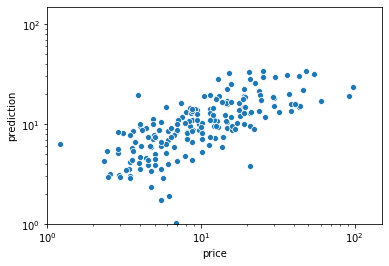

In [597]:
sns.scatterplot(residual_df['price'], residual_df['prediction'])

plt.xscale('log')
plt.yscale('log')
plt.xlim(1,150)
plt.ylim(1,150)

In [548]:
import random

In [738]:
test2=residual_df.loc[random.sample(list(residual_df.index),2)]
test2

,artist,album,price,prediction
216,David Bowie,The Man Who Sold The World,45.45,43.126182
583,Beastie Boys,Hello Nasty,51.06,28.007535


In [664]:
test=residual_df.loc[[395,273,983,72,23,182,104,541,140,934,536,897,387,894,197,180,664,548,959,572,905,792,309,76,288]]

In [733]:
test=residual_df.loc[[395,273,983,72,23,182,104,541,140,934,536,897,387,894,197,180,664,548,959,572,905,792,309,76,288]]
test

,artist,album,price,prediction
395,Steely Dan,Can't Buy A Thrill,20.00,14.924124
273,Hendrix,Band Of Gypsys,16.50,30.935800
983,Lil Louis,French Kiss,16.49,28.727177
72,Metallica,...And Justice For All,59.98,52.003362
23,Bruce Springsteen,Born In The U.S.A.,10.00,8.313821
182,Pink Floyd,A Momentary Lapse Of Reason,20.12,12.526745
104,Van Halen,Van Halen,10.00,32.031445
541,Lennon,Shaved Fish,6.24,16.591598
140,Van Halen,1984,15.00,15.583007
934,The Beatles,Love Songs,9.12,20.822346


In [734]:
np.sum(np.abs(test['price'] - test['prediction']))/25

16.942972625687077

In [561]:
residuals_train = lm.predict(X_train.iloc[:,2:]) - y_train

In [565]:
y_train_predict = lm.predict(X_train.iloc[:,2:])

In [701]:
train_residuals_df=pd.DataFrame({'y_train_predict':y_train_predict,'y_train':y_train,'residual':residuals_train})

In [872]:
train_residuals_df['actual_residual']=train_residuals_df['y_train_predict_price']-train_residuals_df['y_train_price']

In [873]:
train_residuals_df.sort_values('actual_residual')

,y_train_predict,y_train,residual,y_train_predict_price,y_train_price,residual_price,actual_residual,increase_estimate,new_estimate,new_error
234,4.316909,7.061334,-2.744426,74.956335,1165.994462,0.064285,-1091.038127,9.557345,84.513680,-1081.480782
196,4.133648,6.871288,-2.737640,62.404996,964.185544,0.064723,-901.780548,6.549092,68.954088,-895.231455
102,3.272352,6.781795,-3.509443,26.373231,881.645978,0.029914,-855.272747,2.212736,28.585967,-853.060011
976,3.484810,6.201543,-2.716733,32.616159,493.507941,0.066090,-460.891782,2.670420,35.286579,-458.221363
580,4.968393,6.213427,-1.245035,143.795072,499.407913,0.287931,-355.612840,0.000000,143.795072,-355.612840
...,...,...,...,...,...,...,...,...,...,...
504,4.460855,3.350606,1.110250,86.561250,28.519936,3.035114,58.041314,0.000000,86.561250,58.041314
459,4.549241,3.496508,1.052733,94.560322,32.999922,2.865471,61.560399,0.000000,94.560322,61.560399
546,5.735644,5.508376,0.227269,309.711308,246.749086,1.255167,62.962222,0.000000,309.711308,62.962222
579,4.195536,0.993252,3.202284,66.389109,2.699998,24.588575,63.689111,7.383945,73.773054,71.073056


In [796]:
np.log(-1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


nan

In [757]:
np.log(1)-np.log(10)

-2.302585092994046

In [758]:
np.log(1/10)

-2.3025850929940455

In [768]:
e**(1-2)

0.36787944117144233

In [767]:
e**1/e**2

0.36787944117144233

In [759]:
e**(1/10)

1.1051709180756477

In [762]:
e**(np.log(1))-e**(np.log(10))

-9.000000000000002

In [765]:
e**(np.log(1))/e**(np.log(10))

0.09999999999999998

In [763]:
e**(np.log(1/10))

0.10000000000000003

In [744]:
train_residuals_df['actual_residual']=train_residuals_df['y_train_price']-train_residuals_df['y_train_predict_price']

In [709]:
np.sum((train_residuals_df['y_train_price']-train_residuals_df['y_train_predict_price'])**2)/786

4826.518227040379

In [ ]:
train_residuals_

In [716]:
np.sum(np.abs(train_residuals_df['y_train_price']- \
              train_residuals_df['y_train_predict_price']))/786

18.904752553993312

In [721]:
e=math.e

In [685]:
np.sqrt(np.sum((y_train_predict-y_train)**2)/len(y_train))

0.6290713462770039

In [700]:
np.sqrt(np.sum((e**y_train_predict-e**y_train)**2)/len(y_train))

69.47314752507172

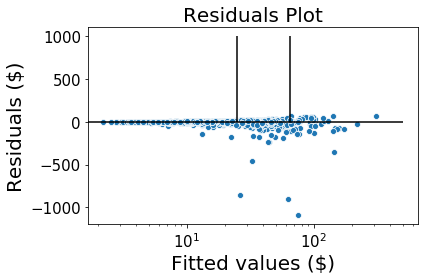

In [896]:
sns.scatterplot(x=train_residuals_df['y_train_predict_price'], y=train_residuals_df['actual_residual'])
plt.xlabel("Fitted values ($)", fontsize=20)
plt.ylabel("Residuals ($)",fontsize=20)
plt.title('Residuals Plot',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.xscale('log')
#plt.yscale('log')
plt.hlines(0,0,500)
plt.vlines(25,0,1000)
plt.vlines(65,0,1000)
plt.tight_layout()
plt.savefig('residuals_plot_dollarvsdollar.tiff')

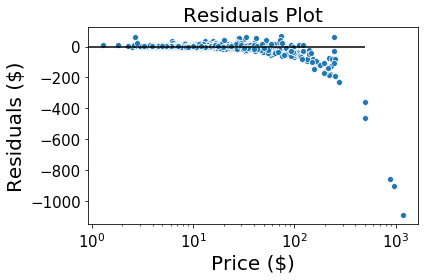

In [875]:
sns.scatterplot(x=train_residuals_df['y_train_price'], y=train_residuals_df['actual_residual'])
plt.xlabel("Price ($)", fontsize=20)
plt.ylabel("Residuals ($)",fontsize=20)
plt.title('Residuals Plot',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.xscale('log')
#plt.yscale('log')
plt.hlines(0,0,500)
plt.tight_layout()

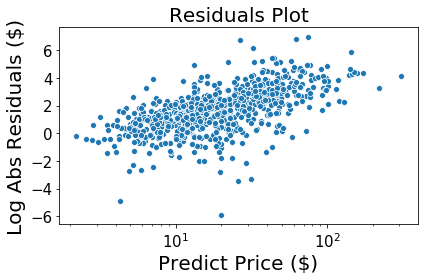

In [876]:
sns.scatterplot(x=train_residuals_df['y_train_predict_price'], y=np.log(np.abs(train_residuals_df['actual_residual'])))
plt.xlabel("Predict Price ($)", fontsize=20)
plt.ylabel("Log Abs Residuals ($)",fontsize=20)
plt.title('Residuals Plot',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.xscale('log')
#plt.yscale('log')
plt.tight_layout()

In [877]:
lm_resid = LinearRegression()
lm_resid.fit(train_residuals_df['y_train_predict_price'].values.reshape(-1, 1), np.log(np.abs(train_residuals_df['actual_residual'])))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [878]:
lm_resid.coef_

array([0.03011575])

In [879]:
lm_resid.intercept_

0.8973108233823487

In [825]:
#increase_estimate= e**(0.030115 * predict_price)

In [899]:
train_residuals_df['increase_estimate'] =  e** (0.89+0.030115 * train_residuals_df['y_train_predict_price'])

In [900]:
train_residuals_df.loc[(train_residuals_df['y_train_predict_price'] < 25) | (train_residuals_df['y_train_predict_price'] > 65),'increase_estimate'] = 0

In [901]:
train_residuals_df['new_estimate'] = train_residuals_df['y_train_predict_price'] + train_residuals_df['increase_estimate'] 

In [902]:
train_residuals_df['new_error'] = train_residuals_df['new_estimate'] - train_residuals_df['y_train_price'] 

In [903]:
np.mean(np.abs(train_residuals_df['new_error']))

19.152226685297347

In [904]:
np.mean(np.abs(train_residuals_df['actual_residual']))

18.904752553993315

In [905]:
pd.set_option('display.max_rows', 200)
train_residuals_df.sort_values('increase_estimate').tail(200)

,y_train_predict,y_train,residual,y_train_predict_price,y_train_price,residual_price,actual_residual,increase_estimate,new_estimate,new_error
972,3.316379,4.068001,-0.751622,27.560299,58.439840,0.471601,-30.879541,5.584408,33.144707,-25.295133
479,3.319723,3.749504,-0.429781,27.652620,42.499893,0.650652,-14.847272,5.599956,33.252576,-9.247317
85,3.319864,2.790551,0.529313,27.656529,16.289969,1.697764,11.366559,5.600615,33.257143,16.967174
673,3.322685,2.302585,1.020100,27.734664,9.999985,2.773471,17.734679,5.613809,33.348472,23.348488
991,3.324053,3.851423,-0.527370,27.772636,47.059878,0.590155,-19.287242,5.620232,33.392868,-13.667011
278,3.324224,3.555348,-0.231124,27.777385,34.999916,0.793641,-7.222531,5.621036,33.398421,-1.601496
631,3.333379,3.875774,-0.542395,28.032845,48.219874,0.581355,-20.187030,5.664446,33.697291,-14.522583
709,3.334870,2.981633,0.353237,28.074678,19.719960,1.423668,8.354717,5.671587,33.746264,14.026304
714,3.334889,2.935451,0.399438,28.075217,18.829963,1.490986,9.245254,5.671679,33.746896,14.916933
58,3.335496,3.480932,-0.145436,28.092253,32.489924,0.864645,-4.397671,5.674589,33.766842,1.276918


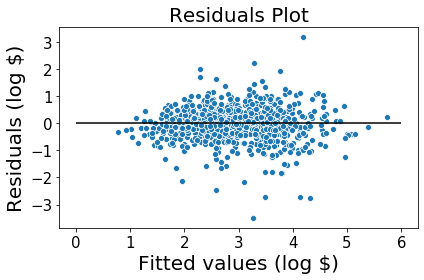

In [778]:
sns.scatterplot(x=lm.predict(X_train.iloc[:,2:]), y=lm.predict(X_train.iloc[:,2:])-y_train)
plt.xlabel("Fitted values (log $)", fontsize=20)
plt.ylabel("Residuals (log $)",fontsize=20)
plt.title('Residuals Plot',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


#plt.xscale('log')
#plt.yscale('log')
plt.hlines(0,0,6)
plt.tight_layout()
plt.savefig('residuals_plot_log$vslog$.tiff')

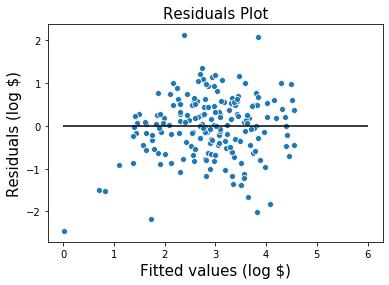

In [604]:
sns.scatterplot(x=predictions, y=residuals)
plt.xlabel("Fitted values (log $)", fontsize=15)
plt.ylabel("Residuals (log $)",fontsize=15)
plt.title('Residuals Plot',fontsize=15)

plt.hlines(0,0,6)


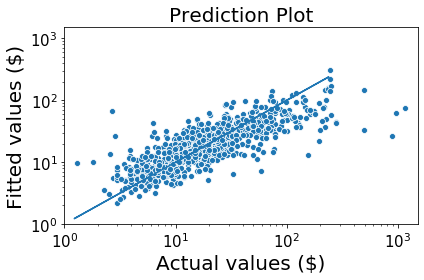

In [780]:
sns.scatterplot(x=e**y_train, y=e**y_train_predict)
plt.xlabel("Actual values ($)", fontsize=20)
plt.ylabel("Fitted values ($)",fontsize=20)
plt.title('Prediction Plot',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(2.17**y_train, 2.17**y_train)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,1500)
plt.ylim(1,1500)
plt.tight_layout()
plt.savefig('Prediction Plot.tiff')


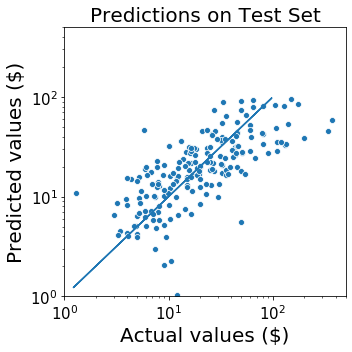

In [741]:
plt.figure(figsize=(5,5))
sns.scatterplot(x=actual, y=predictions)
plt.xlabel("Actual values ($)", fontsize=20)
plt.ylabel("Predicted values ($)",fontsize=20)
plt.xscale("log")
plt.yscale("log")
plt.xlim(1,500)
plt.ylim(1,500)
plt.plot(2.17**y_test, 2.17**y_test)

plt.title("Predictions on Test Set", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('Test Set predictions.tiff')

In [572]:
from statsmodels.graphics.gofplots import qqplot

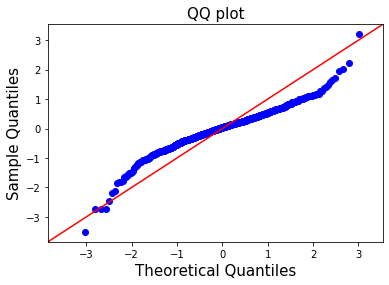

In [682]:
qqplot(residuals_train,line='45')
plt.xlabel("Theoretical Quantiles", fontsize=15)
plt.ylabel("Sample Quantiles",fontsize=15)
plt.title('QQ plot',fontsize=15)
plt.savefig('QQ.tiff')

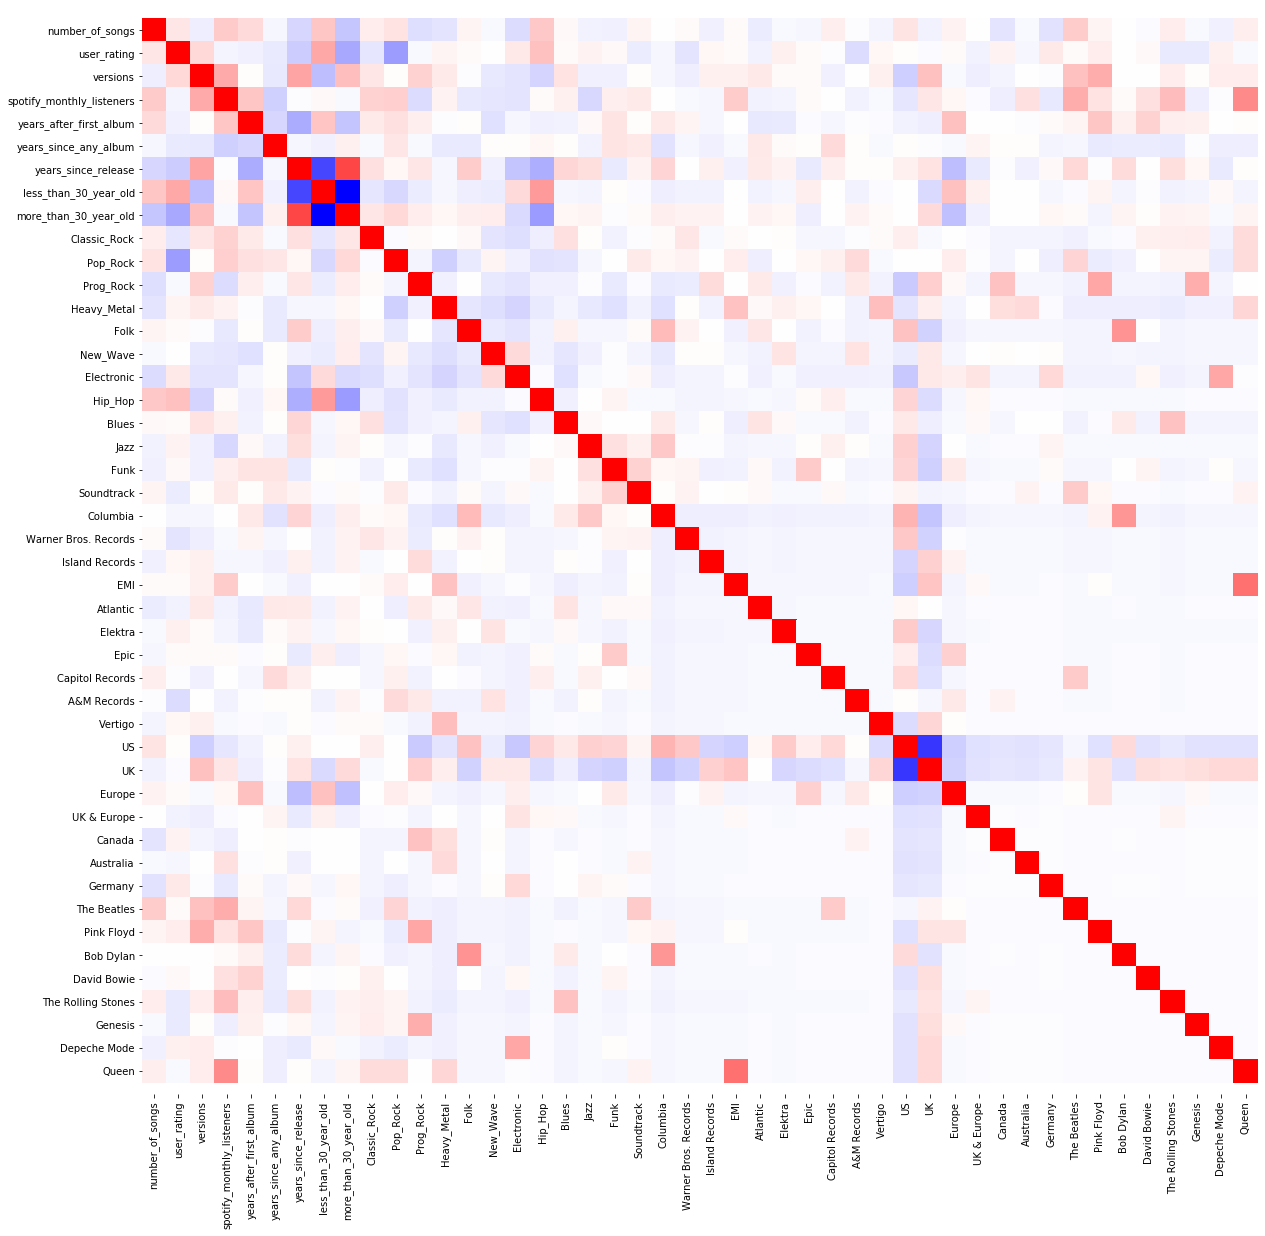

In [766]:
plt.rcParams['font.size'] = 10

plt.figure(figsize=(20,20))

sns.heatmap(X_train.iloc[:,2:48].corr(), cmap="bwr", annot=False, vmin=-1, vmax=1, fmt='.2f', cbar=False)

plt.gca().set_ylim(len(X_train.iloc[:,2:48].corr())+0.5, -0.5);  # quick fix to make sure viz isn't cut off